In [12]:
import pandas as pd
df = pd.read_csv("/home/ashken.edirisinghe/Downloads/graf30_with_time_features_extended.csv")

In [13]:
df = df.dropna()  # Drop any missing rows

df.fillna(method="ffill", inplace=True)  # Forward fill missing values


/tmp/ipykernel_69992/3466441258.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)  # Forward fill missing values


In [14]:
df = df.drop_duplicates()
df

Timestamp  Cluster ID Team Name  Chart Name  \
0       2025-02-13 16:11:50.524049           2        DE  PostgreSQL   
1       2025-02-13 17:11:50.524049           2        DE  PostgreSQL   
2       2025-02-13 18:11:50.524049           2        DE  PostgreSQL   
3       2025-02-13 19:11:50.524049           2        DE  PostgreSQL   
4       2025-02-13 20:11:50.524049           2        DE  PostgreSQL   
...                            ...         ...       ...         ...   
298795  2025-03-15 11:11:50.524049         120        ML       Spark   
298796  2025-03-15 12:11:50.524049         120        ML       Spark   
298797  2025-03-15 13:11:50.524049         120        ML       Spark   
298798  2025-03-15 14:11:50.524049         120        ML       Spark   
298799  2025-03-15 15:11:50.524049         120        ML       Spark   

            CPU Used  Memory Used (GB)  Storage Used (GB)  Hour  Minute  \
0        6324.992781          8.780397         132.669369    16      11   
1        7604.791454         14.561455         248.910517    17      11   
2        5628.132575         11.967799         185.172891    18      11   
3        6981.990227         10.011216         187.333509    19      11   
4        5094.371216          6.862302         126.932511    20      11   
...              ...               ...                ...   ...     ...   
298795  21987.691065         40.987461         274.085709    11      11   
298796  17061.135183         47.629142         294.922251    12      11   
298797  36079.648829         60.268970         496.842960    13      11   
298798  21529.673384         41.837138         262.794964    14      11   
298799  23754.976828         48.843393         288.301589    15      11   

        DayOfWeek  IsWeekend  Month  
0               3          0      2  
1               3          0      2  
2               3          0      2  
3               3          0      2  
4               3          0      2  
...           ...        ...    ...  
298795          5          1      3  
298796          5          1      3  
298797          5          1      3  
298798          5          1      3  
298799          5          1      3  

[298800 rows x 12 columns]

In [15]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

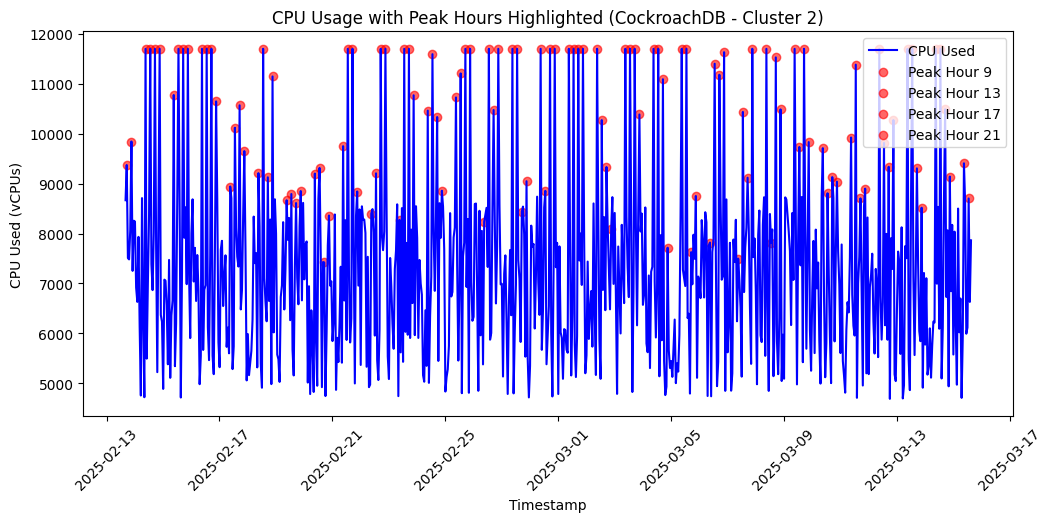

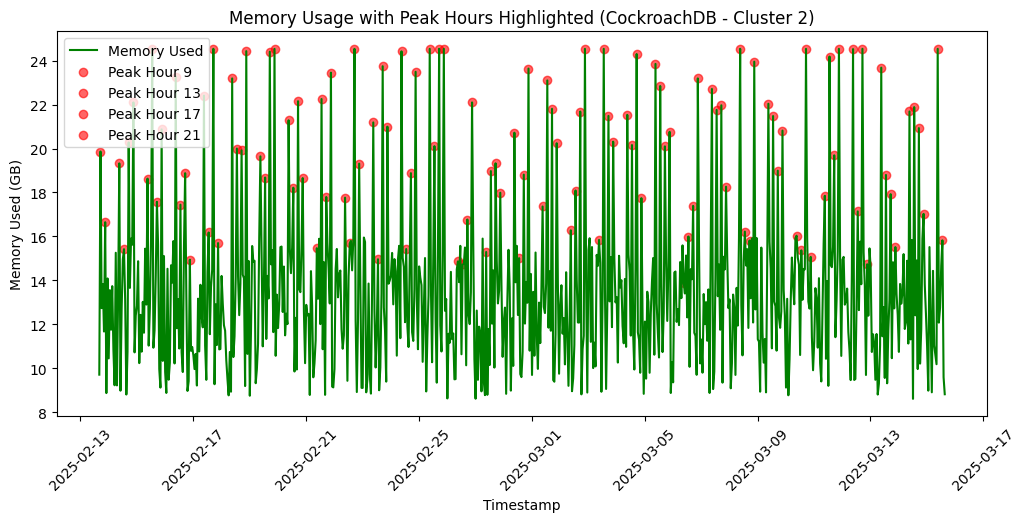

In [16]:
import matplotlib.pyplot as plt
# Select a sample cluster and chart
sample_cluster = 2  # Example: Cluster 2
sample_chart = "CockroachDB"  # Example chart

# Filter dataset for the selected cluster and chart
df_sample = df[(df["Cluster ID"] == sample_cluster) & (df["Chart Name"] == sample_chart)].copy()

# Extract timestamps and resource usage
df_sample["Hour"] = df_sample["Timestamp"].dt.hour

# Define expected peak hours for this cluster
peak_hours = [9, 13, 17, 21]

# Plot CPU usage over time
plt.figure(figsize=(12, 5))
plt.plot(df_sample["Timestamp"], df_sample["CPU Used"], label="CPU Used", color="blue")

# Highlight peak hours
for hour in peak_hours:
    peak_times = df_sample[df_sample["Hour"] == hour]["Timestamp"]
    peak_values = df_sample[df_sample["Hour"] == hour]["CPU Used"]
    plt.scatter(peak_times, peak_values, color="red", label=f"Peak Hour {hour}", alpha=0.6)

plt.title(f"CPU Usage with Peak Hours Highlighted ({sample_chart} - Cluster {sample_cluster})")
plt.xlabel("Timestamp")
plt.ylabel("CPU Used (vCPUs)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Repeat for Memory and Storage Usage
plt.figure(figsize=(12, 5))
plt.plot(df_sample["Timestamp"], df_sample["Memory Used (GB)"], label="Memory Used", color="green")

for hour in peak_hours:
    peak_times = df_sample[df_sample["Hour"] == hour]["Timestamp"]
    peak_values = df_sample[df_sample["Hour"] == hour]["Memory Used (GB)"]
    plt.scatter(peak_times, peak_values, color="red", label=f"Peak Hour {hour}", alpha=0.6)

plt.title(f"Memory Usage with Peak Hours Highlighted ({sample_chart} - Cluster {sample_cluster})")
plt.xlabel("Timestamp")
plt.ylabel("Memory Used (GB)")
plt.legend()
plt.xticks(rotation=45)
plt.show()


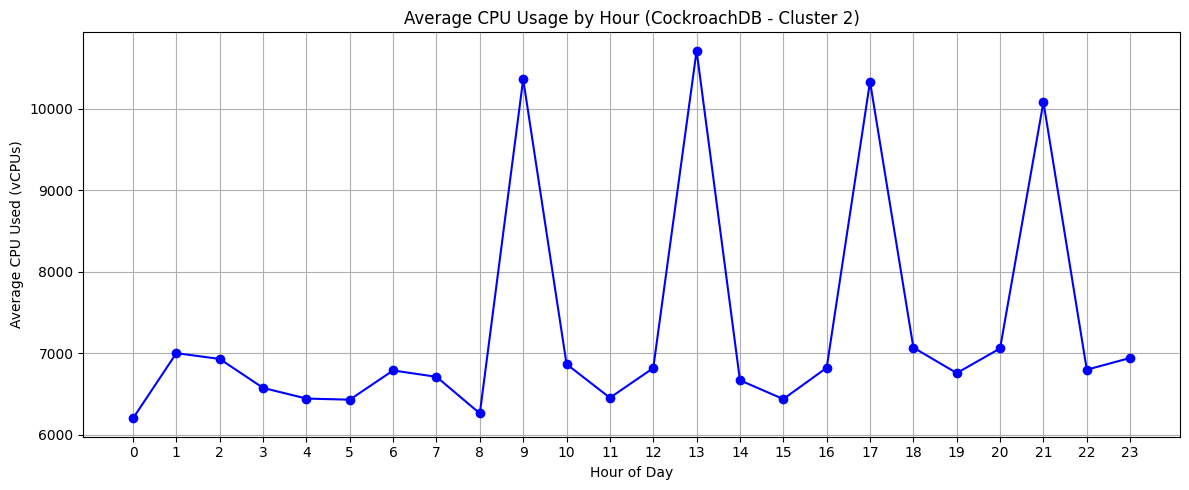

In [17]:
# Group by hour of day
hourly_avg = df_sample.groupby("Hour")[["CPU Used", "Memory Used (GB)"]].mean().reset_index()

# Plot CPU separately
plt.figure(figsize=(12, 5))
plt.plot(hourly_avg["Hour"], hourly_avg["CPU Used"], marker='o', color="blue")
plt.title(f"Average CPU Usage by Hour ({sample_chart} - Cluster {sample_cluster})")
plt.xlabel("Hour of Day")
plt.ylabel("Average CPU Used (vCPUs)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


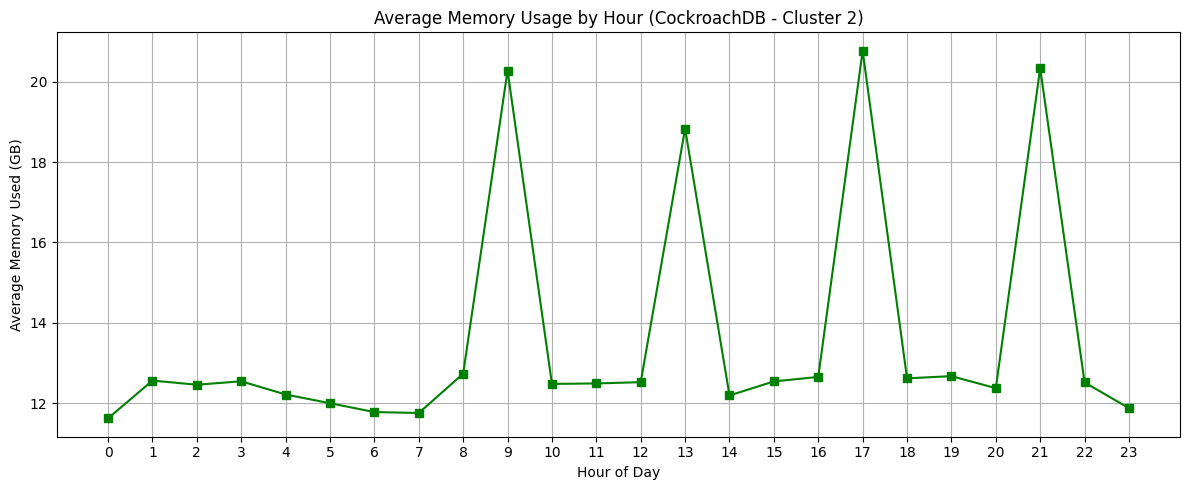

In [18]:
# Plot Memory separately
plt.figure(figsize=(12, 5))
plt.plot(hourly_avg["Hour"], hourly_avg["Memory Used (GB)"], marker='s', color="green")
plt.title(f"Average Memory Usage by Hour ({sample_chart} - Cluster {sample_cluster})")
plt.xlabel("Hour of Day")
plt.ylabel("Average Memory Used (GB)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


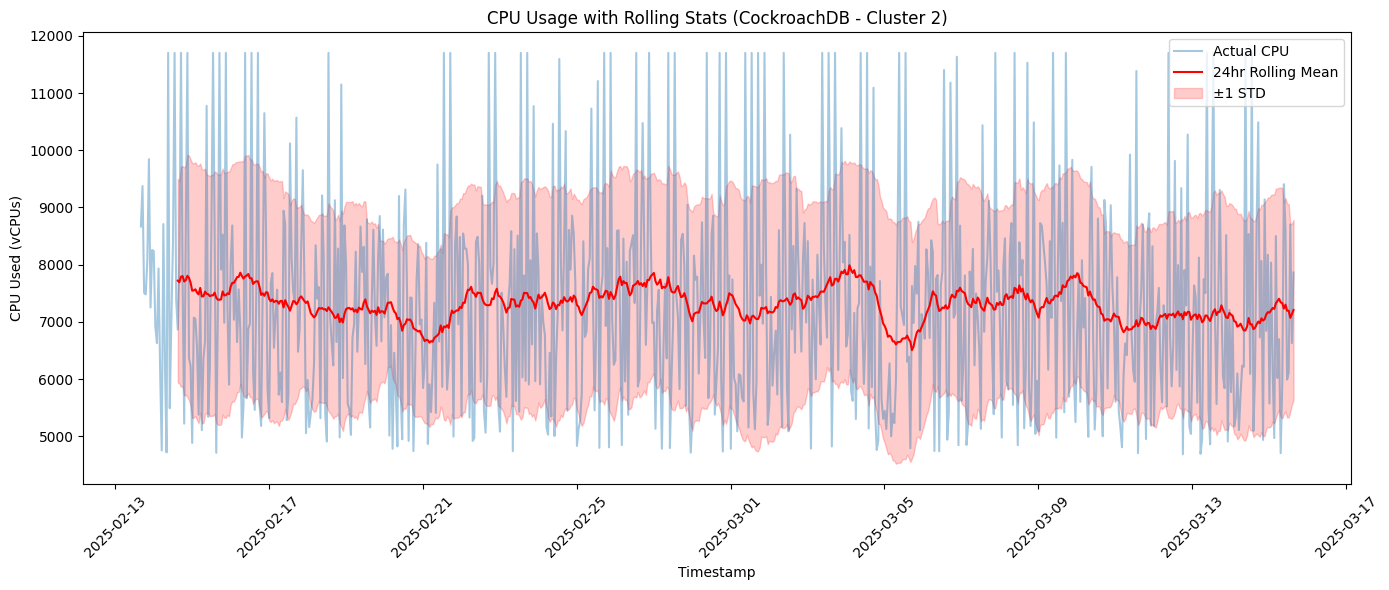

In [19]:
# Compute rolling mean and std deviation for CPU
df_sample_sorted = df_sample.sort_values("Timestamp")
df_sample_sorted["CPU_Rolling_Mean"] = df_sample_sorted["CPU Used"].rolling(window=24).mean()
df_sample_sorted["CPU_Rolling_STD"] = df_sample_sorted["CPU Used"].rolling(window=24).std()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_sample_sorted["Timestamp"], df_sample_sorted["CPU Used"], label="Actual CPU", alpha=0.4)
plt.plot(df_sample_sorted["Timestamp"], df_sample_sorted["CPU_Rolling_Mean"], label="24hr Rolling Mean", color="red")
plt.fill_between(df_sample_sorted["Timestamp"],
                 df_sample_sorted["CPU_Rolling_Mean"] - df_sample_sorted["CPU_Rolling_STD"],
                 df_sample_sorted["CPU_Rolling_Mean"] + df_sample_sorted["CPU_Rolling_STD"],
                 color='red', alpha=0.2, label="±1 STD")
plt.title(f"CPU Usage with Rolling Stats ({sample_chart} - Cluster {sample_cluster})")
plt.xlabel("Timestamp")
plt.ylabel("CPU Used (vCPUs)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_69992/3274037258.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sample, x="Hour", y="CPU Used", palette="Blues")


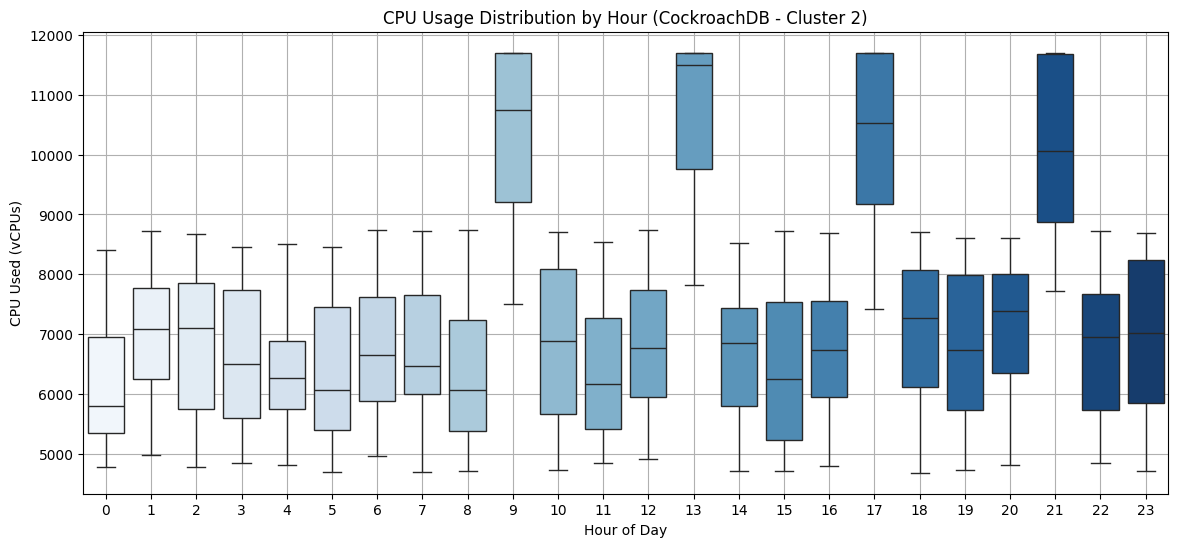

/tmp/ipykernel_69992/3274037258.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sample, x="Hour", y="Memory Used (GB)", palette="Greens")


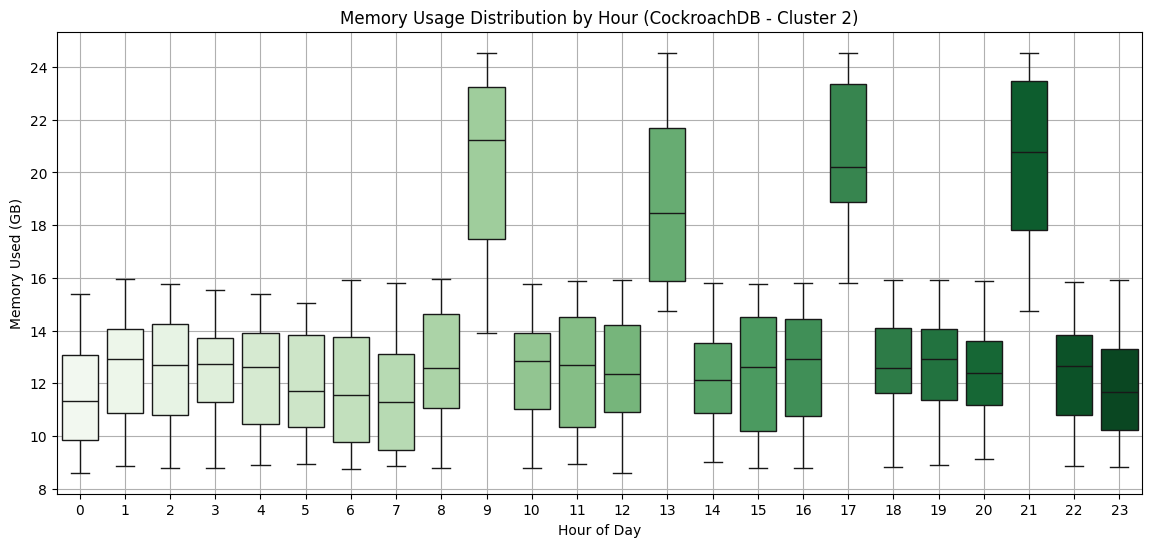

In [20]:
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_sample, x="Hour", y="CPU Used", palette="Blues")
plt.title(f"CPU Usage Distribution by Hour ({sample_chart} - Cluster {sample_cluster})")
plt.xlabel("Hour of Day")
plt.ylabel("CPU Used (vCPUs)")
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_sample, x="Hour", y="Memory Used (GB)", palette="Greens")
plt.title(f"Memory Usage Distribution by Hour ({sample_chart} - Cluster {sample_cluster})")
plt.xlabel("Hour of Day")
plt.ylabel("Memory Used (GB)")
plt.grid(True)
plt.show()


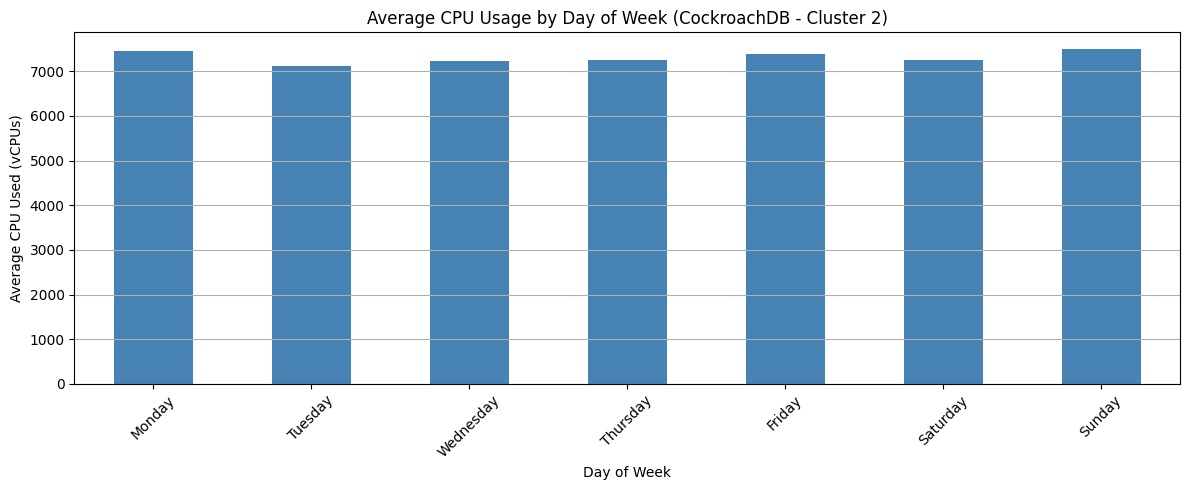

In [21]:
# Add day of week if not already added
df_sample["DayOfWeek"] = df_sample["Timestamp"].dt.day_name()

# Compute average CPU and memory usage grouped by weekday
weekly_avg = df_sample.groupby("DayOfWeek")[["CPU Used", "Memory Used (GB)"]].mean()
weekly_avg = weekly_avg.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# Plot CPU separately
plt.figure(figsize=(12, 5))
weekly_avg["CPU Used"].plot(kind='bar', color='steelblue')
plt.title(f"Average CPU Usage by Day of Week ({sample_chart} - Cluster {sample_cluster})")
plt.xlabel("Day of Week")
plt.ylabel("Average CPU Used (vCPUs)")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


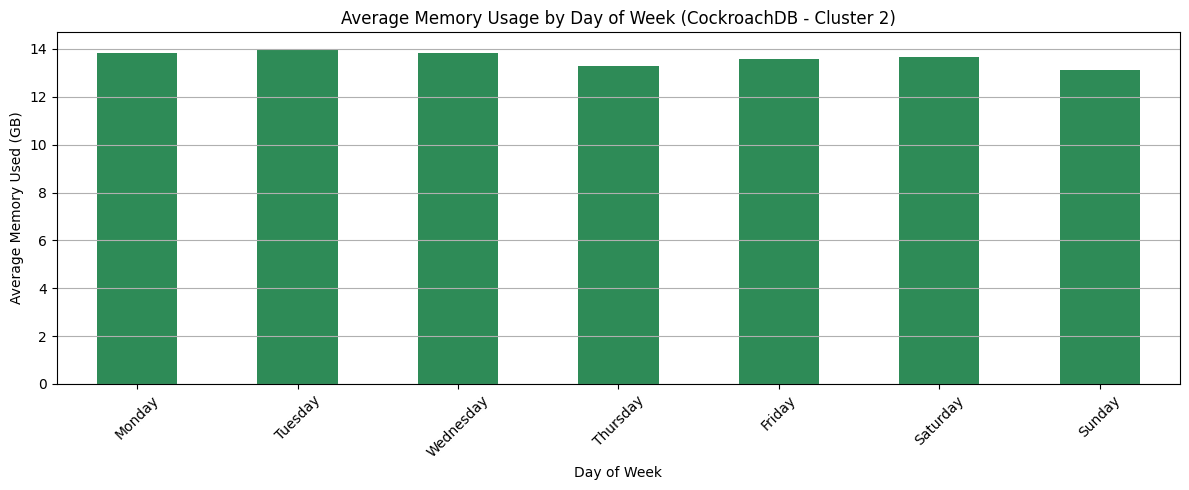

In [22]:
# Plot Memory separately
plt.figure(figsize=(12, 5))
weekly_avg["Memory Used (GB)"].plot(kind='bar', color='seagreen')
plt.title(f"Average Memory Usage by Day of Week ({sample_chart} - Cluster {sample_cluster})")
plt.xlabel("Day of Week")
plt.ylabel("Average Memory Used (GB)")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


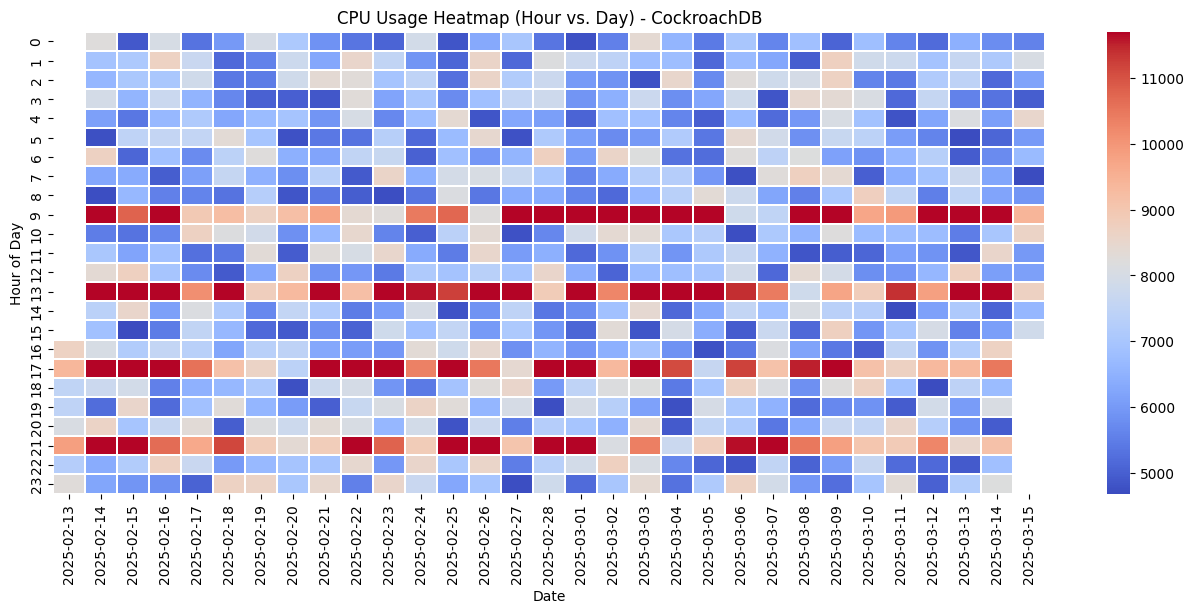

In [23]:
# Create pivot for heatmap
df_sample["Date"] = df_sample["Timestamp"].dt.date
cpu_pivot = df_sample.pivot_table(index="Hour", columns="Date", values="CPU Used", aggfunc="mean")

plt.figure(figsize=(16, 6))
sns.heatmap(cpu_pivot, cmap="coolwarm", linewidths=0.2)
plt.title(f"CPU Usage Heatmap (Hour vs. Day) - {sample_chart}")
plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.show()


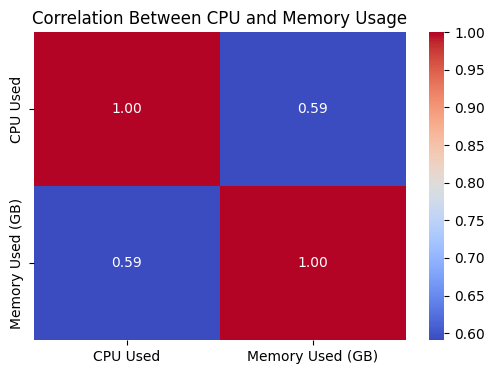

In [24]:
import seaborn as sns

# Use original df_sample
corr_matrix = df_sample[["CPU Used", "Memory Used (GB)"]].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between CPU and Memory Usage")
plt.show()


ARIMA

/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

Best ARIMA Order: (2, 0, 2) (AIC: 10184.31)


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

Best ARIMA Order: (2, 0, 2) (AIC: 3002.47)
Optimized ARIMA Model Evaluation for CockroachDB in Cluster 2:
CPU Usage - MAE: 1287.13, RMSE: 1557.71, MAPE: 19.54%
Memory Usage - MAE: 2.52, RMSE: 3.22, MAPE: 19.28%


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


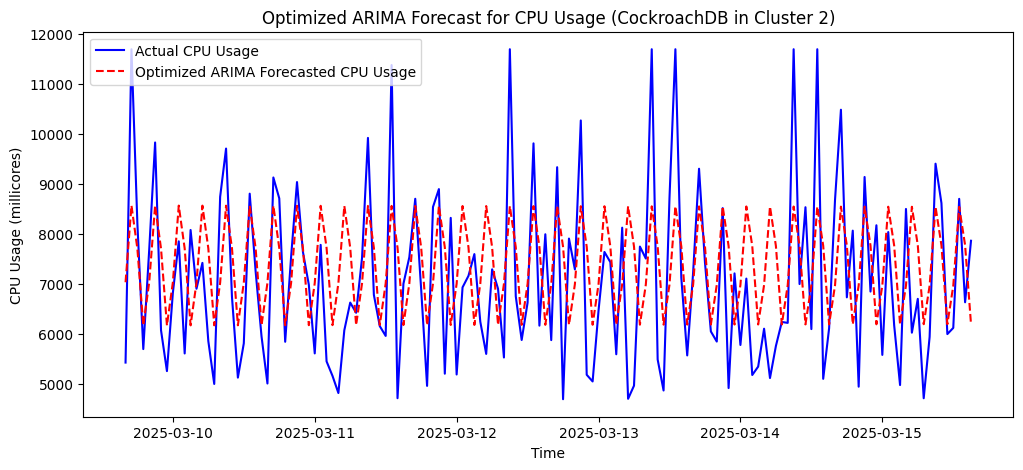

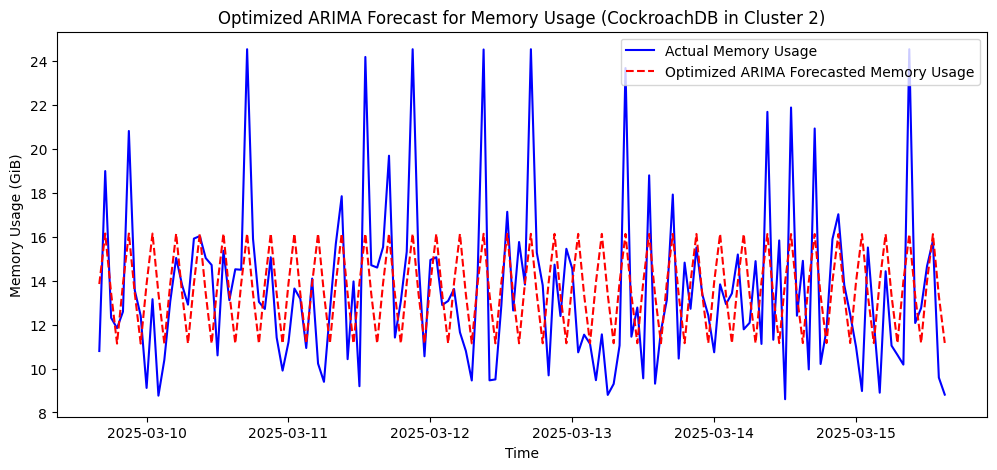

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the resampled dataset
file_path = "/home/ashken.edirisinghe/Downloads/resampled_application_level.csv"  
df = pd.read_csv(file_path)

# Convert Timestamp to datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Select a sample application from a specific cluster
sample_cluster = df["Cluster ID"].unique()[0]  # Select the first cluster ID
sample_chart = df[df["Cluster ID"] == sample_cluster]["Chart Name"].unique()[0]  

# Filter data for the selected application in the selected cluster
df_sample = df[(df["Cluster ID"] == sample_cluster) & (df["Chart Name"] == sample_chart)]

# Set timestamp as index
df_sample = df_sample.set_index("Timestamp")

# Keep only CPU and Memory usage for prediction
df_sample = df_sample[["CPU Used", "Memory Used (GB)"]]

# Split the dataset into training and testing sets (80% train, 20% test)
train_size = int(len(df_sample) * 0.8)
train, test = df_sample[:train_size], df_sample[train_size:]

# Define function to perform ARIMA Grid Search for best (p, d, q)
def arima_grid_search(train_series, p_range=(0, 3), d_range=(0, 2), q_range=(0, 3)):
    """
    Performs a grid search over ARIMA (p, d, q) values and selects the best model based on AIC.
    :param train_series: The training time-series data
    :param p_range: Tuple defining the range of p values to search
    :param d_range: Tuple defining the range of d values to search
    :param q_range: Tuple defining the range of q values to search
    :return: Best (p, d, q) order
    """
    best_aic = np.inf
    best_order = None
    best_model = None

    # Create a grid of (p, d, q) values
    pdq_combinations = list(itertools.product(range(*p_range), range(*d_range), range(*q_range)))

    for order in pdq_combinations:
        try:
            model = ARIMA(train_series, order=order)
            model_fit = model.fit()
            aic = model_fit.aic  # Akaike Information Criterion 

            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_model = model_fit

        except:
            continue  # Skip invalid parameter sets

    print(f"Best ARIMA Order: {best_order} (AIC: {best_aic:.2f})")
    return best_order, best_model

# Run Grid Search for CPU and Memory separately
best_order_cpu, cpu_model = arima_grid_search(train["CPU Used"])
best_order_memory, memory_model = arima_grid_search(train["Memory Used (GB)"])

# Function to forecast using best ARIMA model
def forecast_arima(model, test_series):
    """
    Uses the trained ARIMA model to forecast the next time steps.
    :param model: Trained ARIMA model
    :param test_series: The testing time-series data
    :return: Forecasted values
    """
    return model.forecast(steps=len(test_series))

# Get forecasted values
cpu_forecast = forecast_arima(cpu_model, test["CPU Used"])
memory_forecast = forecast_arima(memory_model, test["Memory Used (GB)"])

# Evaluate the model using MAE, RMSE, and MAPE
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # MAPE calculation, handling potential divide-by-zero cases
    actual_nonzero = actual.replace(0, np.nan)  # Replace zeros with NaN to avoid division errors
    mape = np.nanmean(np.abs((actual_nonzero - predicted) / actual_nonzero)) * 100  # MAPE formula
    
    return mae, rmse, mape

# Calculate errors for CPU and Memory
cpu_mae, cpu_rmse, cpu_mape = evaluate_forecast(test["CPU Used"], cpu_forecast)
memory_mae, memory_rmse, memory_mape = evaluate_forecast(test["Memory Used (GB)"], memory_forecast)

# Print evaluation results with MAPE (%)
print(f"Optimized ARIMA Model Evaluation for {sample_chart} in Cluster {sample_cluster}:")
print(f"CPU Usage - MAE: {cpu_mae:.2f}, RMSE: {cpu_rmse:.2f}, MAPE: {cpu_mape:.2f}%")
print(f"Memory Usage - MAE: {memory_mae:.2f}, RMSE: {memory_rmse:.2f}, MAPE: {memory_mape:.2f}%")

# Plot actual vs forecasted values for CPU
plt.figure(figsize=(12, 5))
plt.plot(test.index, test["CPU Used"], label="Actual CPU Usage", color="blue")
plt.plot(test.index, cpu_forecast, label="Optimized ARIMA Forecasted CPU Usage", color="red", linestyle="dashed")
plt.title(f"Optimized ARIMA Forecast for CPU Usage ({sample_chart} in Cluster {sample_cluster})")
plt.xlabel("Time")
plt.ylabel("CPU Usage (millicores)")
plt.legend()
plt.show()

# Plot actual vs forecasted values for Memory
plt.figure(figsize=(12, 5))
plt.plot(test.index, test["Memory Used (GB)"], label="Actual Memory Usage", color="blue")
plt.plot(test.index, memory_forecast, label="Optimized ARIMA Forecasted Memory Usage", color="red", linestyle="dashed")
plt.title(f"Optimized ARIMA Forecast for Memory Usage ({sample_chart} in Cluster {sample_cluster})")
plt.xlabel("Time")
plt.ylabel("Memory Usage (GiB)")
plt.legend()
plt.show()


LSTM

Epoch 1/50


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1364 - val_loss: 0.0646
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0758 - val_loss: 0.0628
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0731 - val_loss: 0.0609
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0697 - val_loss: 0.0600
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0694 - val_loss: 0.0578
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0687 - val_loss: 0.0599
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0621 - val_loss: 0.0397
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0690 - val_loss: 0.0557
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0629 - val_loss: 0.0419
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0438 - val_loss: 0.0350
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0415 - val_loss: 0.0337
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0418 - val_l

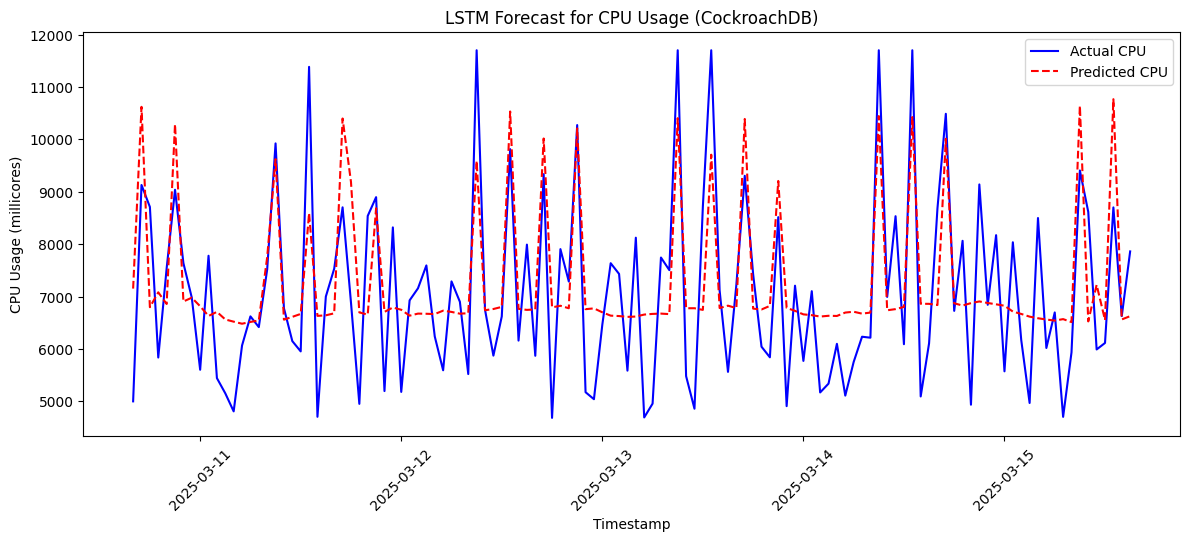

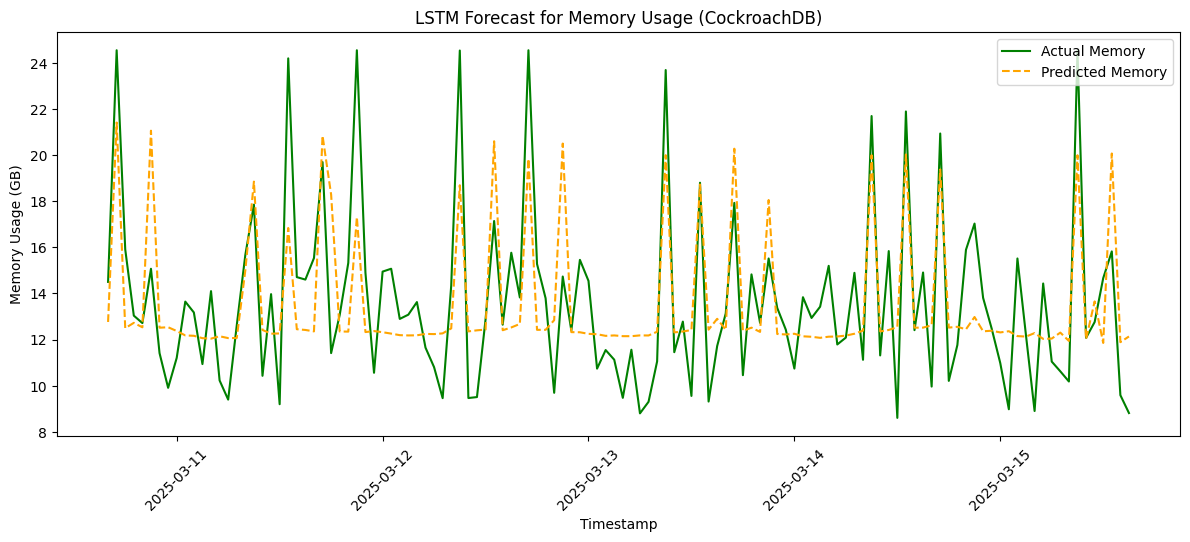


🔹 Sample Predictions vs Actuals
Timestamp                 Actual CPU      Predicted CPU        Actual Mem      Predicted Mem
2025-03-12 12:00:00 6622.19         6804.10              12.86           12.43
2025-03-12 15:00:00 7992.72         6747.09              15.76           12.52
2025-03-10 20:00:00 7539.53         6859.44              12.71           12.53
2025-03-12 23:00:00 5042.67         6775.85              15.45           12.31
2025-03-11 18:00:00 6890.25         9191.16              11.41           18.28
2025-03-13 08:00:00 7505.57         6666.29              11.05           12.34
2025-03-13 17:00:00 9305.89         10390.36             17.92           20.27
2025-03-11 02:00:00 5445.15         6709.31              13.17           12.16
2025-03-12 08:00:00 5522.53         6683.49              14.34           12.48
2025-03-15 03:00:00 4970.45         6618.25              12.17           12.13


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load the resampled dataset
file_path = "/home/ashken.edirisinghe/Downloads/resampled_application_level.csv"  
df = pd.read_csv(file_path)

# Convert Timestamp to datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Select a sample application from a specific cluster
sample_cluster = df["Cluster ID"].unique()[0]
sample_chart = df[df["Cluster ID"] == sample_cluster]["Chart Name"].unique()[0]

# Filter and set index
df_sample = df[(df["Cluster ID"] == sample_cluster) & (df["Chart Name"] == sample_chart)]
df_sample = df_sample.set_index("Timestamp")

# Keep only relevant features
df_sample = df_sample[["CPU Used", "Memory Used (GB)"]].copy()

# Add time-based features
df_sample["Hour"] = df_sample.index.hour
df_sample["DayOfWeek"] = df_sample.index.dayofweek
df_sample["IsWeekend"] = df_sample["DayOfWeek"].isin([5, 6]).astype(int)

# Normalize all features
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(
    scaler.fit_transform(df_sample),
    columns=df_sample.columns,
    index=df_sample.index
)

# Split into train/test
train_size = int(len(scaled_df) * 0.8)
train, test = scaled_df[:train_size], scaled_df[train_size:]

# Sequence creation with time features included
def create_sequences(data, target_columns, lookback=24):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback].values)
        y.append(data.iloc[i+lookback][target_columns].values)
    return np.array(X), np.array(y)

lookback = 24
target_columns = ["CPU Used", "Memory Used (GB)"]
X_train, y_train = create_sequences(train, target_columns, lookback)
X_test, y_test = create_sequences(test, target_columns, lookback)

# Build the LSTM model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(lookback, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(2)  # Output: CPU and Memory
])

model.compile(optimizer='adam', loss='mse')

# Train with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform only CPU and Memory
cpu_mem_scaler = MinMaxScaler()
cpu_mem_scaler.fit(df_sample[["CPU Used", "Memory Used (GB)"]])

# Pad predictions with dummy time features for inverse transform
pad = np.zeros((y_pred.shape[0], scaled_df.shape[1] - 2))
y_pred_padded = np.hstack((y_pred, pad))
y_pred_rescaled = scaler.inverse_transform(y_pred_padded)[:, :2]

y_test_padded = np.hstack((y_test, pad))
y_test_rescaled = scaler.inverse_transform(y_test_padded)[:, :2]

# Evaluation metrics
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / np.maximum(actual, 1e-6))) * 100
    return mae, rmse, mape

cpu_mae, cpu_rmse, cpu_mape = evaluate_forecast(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
mem_mae, mem_rmse, mem_mape = evaluate_forecast(y_test_rescaled[:, 1], y_pred_rescaled[:, 1])

# Print evaluation results
print(f"\nOptimized LSTM with Time Features — {sample_chart} (Cluster {sample_cluster})")
print(f"CPU Usage:    MAE: {cpu_mae:.2f}, RMSE: {cpu_rmse:.2f}, MAPE: {cpu_mape:.2f}%")
print(f"Memory Usage: MAE: {mem_mae:.2f}, RMSE: {mem_rmse:.2f}, MAPE: {mem_mape:.2f}%")

# Plot CPU usage predictions
plt.figure(figsize=(12, 5))
plt.plot(test.index[lookback:], y_test_rescaled[:, 0], label="Actual CPU", color="blue")
plt.plot(test.index[lookback:], y_pred_rescaled[:, 0], label="Predicted CPU", color="red", linestyle="--")
plt.title(f"LSTM Forecast for CPU Usage ({sample_chart})")
plt.xlabel("Timestamp")
plt.ylabel("CPU Usage (millicores)")
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Plot Memory usage predictions
plt.figure(figsize=(12, 5))
plt.plot(test.index[lookback:], y_test_rescaled[:, 1], label="Actual Memory", color="green")
plt.plot(test.index[lookback:], y_pred_rescaled[:, 1], label="Predicted Memory", color="orange", linestyle="--")
plt.title(f"LSTM Forecast for Memory Usage ({sample_chart})")
plt.xlabel("Timestamp")
plt.ylabel("Memory Usage (GB)")
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Show 10 random prediction samples
sample_indices = np.random.choice(len(y_test_rescaled), 10, replace=False)
print("\n🔹 Sample Predictions vs Actuals")
print(f"{'Timestamp':<25} {'Actual CPU':<15} {'Predicted CPU':<20} {'Actual Mem':<15} {'Predicted Mem'}")
print("="*90)
for i in sample_indices:
    timestamp = test.index[lookback:][i]
    print(f"{timestamp} {y_test_rescaled[i,0]:<15.2f} {y_pred_rescaled[i,0]:<20.2f} {y_test_rescaled[i,1]:<15.2f} {y_pred_rescaled[i,1]:.2f}")


Hybrid

Selected Cluster: 2, Selected Chart: CockroachDB


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_mo

Epoch 1/50


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.3200 - val_loss: 0.2150
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2004 - val_loss: 0.0824
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0912 - val_loss: 0.0535
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0701 - val_loss: 0.0772
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0784 - val_loss: 0.0609
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0704 - val_loss: 0.0524
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0587 - val_loss: 0.0525
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0674 - val_loss: 0.0535
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0587 - val_loss: 0.0514
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0586 - val_loss: 0.0511
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0671 - val_loss: 0.0517
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0579 - val_loss: 0.0508
Epoch 13/50


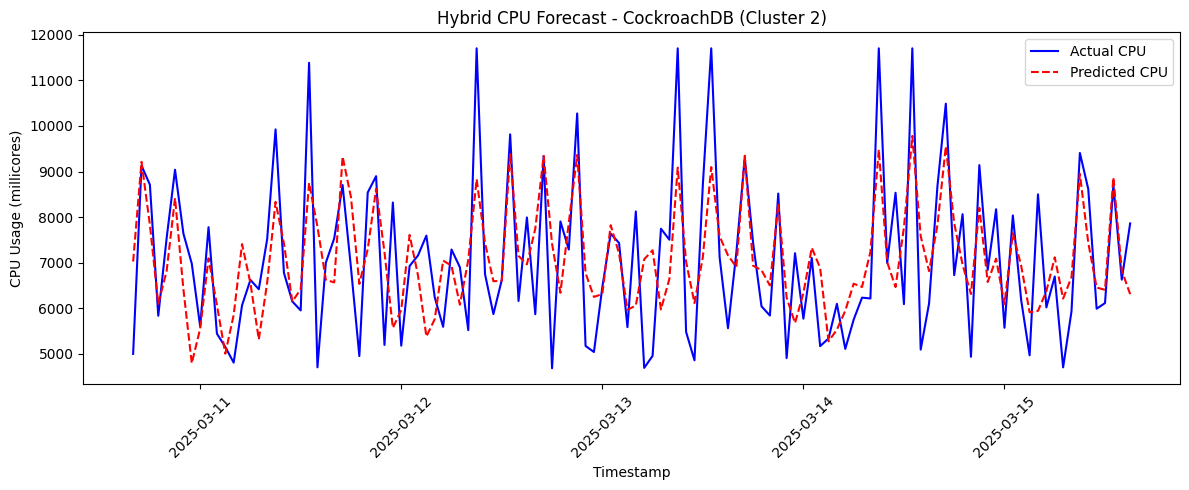

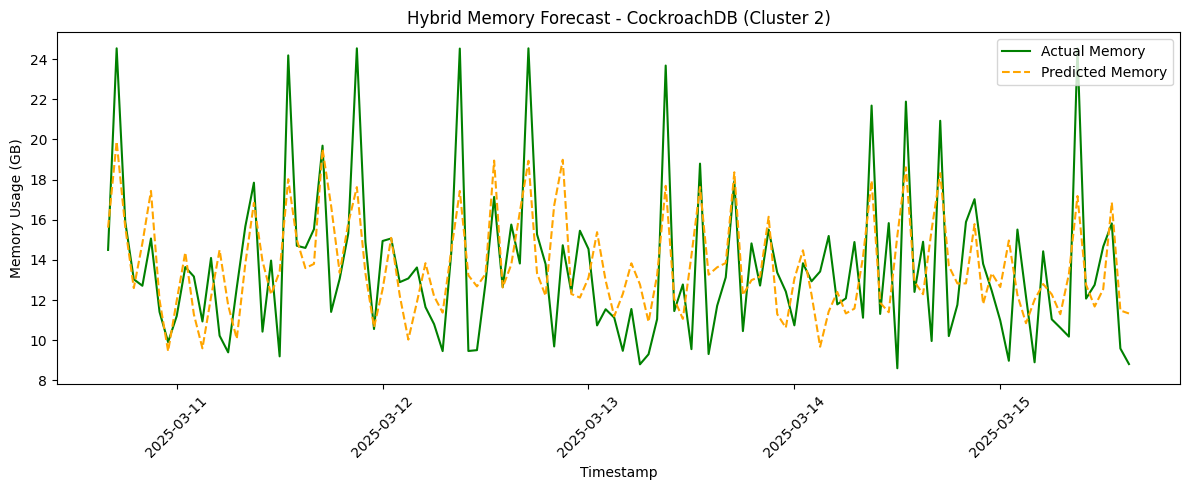

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

#  Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#  Load dataset
df = pd.read_csv("/home/ashken.edirisinghe/Downloads/resampled_application_level.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index("Timestamp", inplace=True)

#  Select a cluster and chart
sample_cluster = df["Cluster ID"].unique()[0]
sample_chart = df[df["Cluster ID"] == sample_cluster]["Chart Name"].unique()[0]
print(f"Selected Cluster: {sample_cluster}, Selected Chart: {sample_chart}")

#  Filter data
df_sample = df[(df["Cluster ID"] == sample_cluster) & (df["Chart Name"] == sample_chart)][["CPU Used", "Memory Used (GB)"]].copy()

#  Normalize full data
scaler_raw = MinMaxScaler()
df_scaled = pd.DataFrame(scaler_raw.fit_transform(df_sample), columns=df_sample.columns, index=df_sample.index)

#  Train-test split
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

#  Train ARIMA models
def train_arima(series, order):
    try:
        model = ARIMA(series, order=order)
        model_fit = model.fit()
        return model_fit.forecast(steps=len(test))
    except Exception as e:
        print(f"ARIMA failed: {e}")
        return None

cpu_forecast = train_arima(train["CPU Used"], (2, 0, 2))
memory_forecast = train_arima(train["Memory Used (GB)"], (2, 0, 2))

if cpu_forecast is None or memory_forecast is None:
    raise ValueError("ARIMA model training failed.")

#  Compute residuals
arima_forecast_df = pd.DataFrame({
    "CPU Used": cpu_forecast, 
    "Memory Used (GB)": memory_forecast
}, index=test.index)

cpu_residuals = test["CPU Used"] - arima_forecast_df["CPU Used"]
memory_residuals = test["Memory Used (GB)"] - arima_forecast_df["Memory Used (GB)"]

#  Feature engineering
residuals_df = pd.DataFrame({
    "CPU Residuals": cpu_residuals,
    "Memory Residuals": memory_residuals
}, index=test.index)

residuals_df["Hour"] = residuals_df.index.hour
residuals_df["DayOfWeek"] = residuals_df.index.dayofweek
residuals_df["IsWeekend"] = residuals_df["DayOfWeek"].isin([5, 6]).astype(int)

#  Normalize residuals + time features
scaler = MinMaxScaler()
features = ["CPU Residuals", "Memory Residuals", "Hour", "DayOfWeek", "IsWeekend"]
residuals_scaled = pd.DataFrame(scaler.fit_transform(residuals_df[features]), columns=features, index=residuals_df.index)

#  Sequence creation
def create_sequences(data, target_cols, lookback=24):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback].values)
        y.append(data.iloc[i+lookback][target_cols].values)
    return np.array(X), np.array(y)

lookback = 24
X_train, y_train = create_sequences(residuals_scaled, ["CPU Residuals", "Memory Residuals"], lookback)
X_test, y_test = create_sequences(residuals_scaled, ["CPU Residuals", "Memory Residuals"], lookback)

#  Build and train LSTM model
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = build_lstm((lookback, X_train.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

#  Predict residuals
residual_pred = lstm_model.predict(X_test)
residual_pred_rescaled = scaler.inverse_transform(
    np.hstack((residual_pred, np.zeros((residual_pred.shape[0], len(features) - 2))))
)[:, :2]

#  Final forecast = ARIMA + predicted residuals
trim_start = len(arima_forecast_df) - len(residual_pred_rescaled)
cpu_final = arima_forecast_df["CPU Used"].values[trim_start:] + residual_pred_rescaled[:, 0]
mem_final = arima_forecast_df["Memory Used (GB)"].values[trim_start:] + residual_pred_rescaled[:, 1]

#  Denormalize final values
cpu_min, cpu_max = df_sample["CPU Used"].min(), df_sample["CPU Used"].max()
mem_min, mem_max = df_sample["Memory Used (GB)"].min(), df_sample["Memory Used (GB)"].max()

actual_cpu = test.iloc[trim_start:]["CPU Used"] * (cpu_max - cpu_min) + cpu_min
actual_mem = test.iloc[trim_start:]["Memory Used (GB)"] * (mem_max - mem_min) + mem_min
pred_cpu = cpu_final * (cpu_max - cpu_min) + cpu_min
pred_mem = mem_final * (mem_max - mem_min) + mem_min

#  Print 10 Random Test Samples
test_samples = pd.DataFrame({
    "Actual CPU (millicores)": actual_cpu.sample(10, random_state=42).values,
    "Predicted CPU (millicores)": pred_cpu[:10],
    "Actual Memory (GB)": actual_mem.sample(10, random_state=42).values,
    "Predicted Memory (GB)": pred_mem[:10]
})

print("\n🔹 10 Random Test Samples (Denormalized):")
print(test_samples)

#  Plot CPU forecast
plt.figure(figsize=(12, 5))
plt.plot(actual_cpu.index, actual_cpu, label="Actual CPU", color="blue")
plt.plot(actual_cpu.index, pred_cpu, label="Predicted CPU", color="red", linestyle="--")
plt.title(f"Hybrid CPU Forecast - {sample_chart} (Cluster {sample_cluster})")
plt.xlabel("Timestamp")
plt.ylabel("CPU Usage (millicores)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Plot Memory forecast
plt.figure(figsize=(12, 5))
plt.plot(actual_mem.index, actual_mem, label="Actual Memory", color="green")
plt.plot(actual_mem.index, pred_mem, label="Predicted Memory", color="orange", linestyle="--")
plt.title(f"Hybrid Memory Forecast - {sample_chart} (Cluster {sample_cluster})")
plt.xlabel("Timestamp")
plt.ylabel("Memory Usage (GB)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

#  Evaluation function
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Avoid division by zero for MAPE
    mape = np.mean(np.abs((actual - predicted) / np.maximum(actual, 1e-6))) * 100

    # Symmetric MAPE
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    denominator = np.where(denominator < 1e-6, 1e-6, denominator)
    smape = np.mean(np.abs(actual - predicted) / denominator) * 100

    return mae, rmse, mape, smape

#  Compute metrics
cpu_mae, cpu_rmse, cpu_mape, cpu_smape = evaluate_forecast(actual_cpu, pred_cpu)
mem_mae, mem_rmse, mem_mape, mem_smape = evaluate_forecast(actual_mem, pred_mem)

print(f"\n Hybrid Model Evaluation for {sample_chart} in Cluster {sample_cluster}:")
print(" CPU Usage (millicores):")
print(f"   - MAE   : {cpu_mae:.2f}")
print(f"   - RMSE  : {cpu_rmse:.2f}")
print(f"   - MAPE  : {cpu_mape:.2f}%")
print(f"   - SMAPE : {cpu_smape:.2f}%")

print("\n Memory Usage (GB):")
print(f"   - MAE   : {mem_mae:.2f}")
print(f"   - RMSE  : {mem_rmse:.2f}")
print(f"   - MAPE  : {mem_mape:.2f}%")
print(f"   - SMAPE : {mem_smape:.2f}%")



 Hybrid Model Evaluation for CockroachDB in Cluster 2:
 CPU Usage (millicores):
   - MAE   : 1037.65
   - RMSE  : 1289.02
   - MAPE  : 15.57%
   - SMAPE : 14.98%

 Memory Usage (GB):
   - MAE   : 2.26
   - RMSE  : 2.87
   - MAPE  : 17.58%
   - SMAPE : 16.59%



Running Hybrid Forecast for: Airflow (Cluster 4)


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_mo

Epoch 1/50


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.3001 - val_loss: 0.2041
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1864 - val_loss: 0.0800
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0875 - val_loss: 0.0560
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0799 - val_loss: 0.0714
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0737 - val_loss: 0.0542
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0735 - val_loss: 0.0535
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0619 - val_loss: 0.0555
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0732 - val_loss: 0.0527
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0645 - val_loss: 0.0522
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0649 - val_loss: 0.0525
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0682 - val_loss: 0.0516
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0612 - val_loss: 0.0511
Epoch 13/50


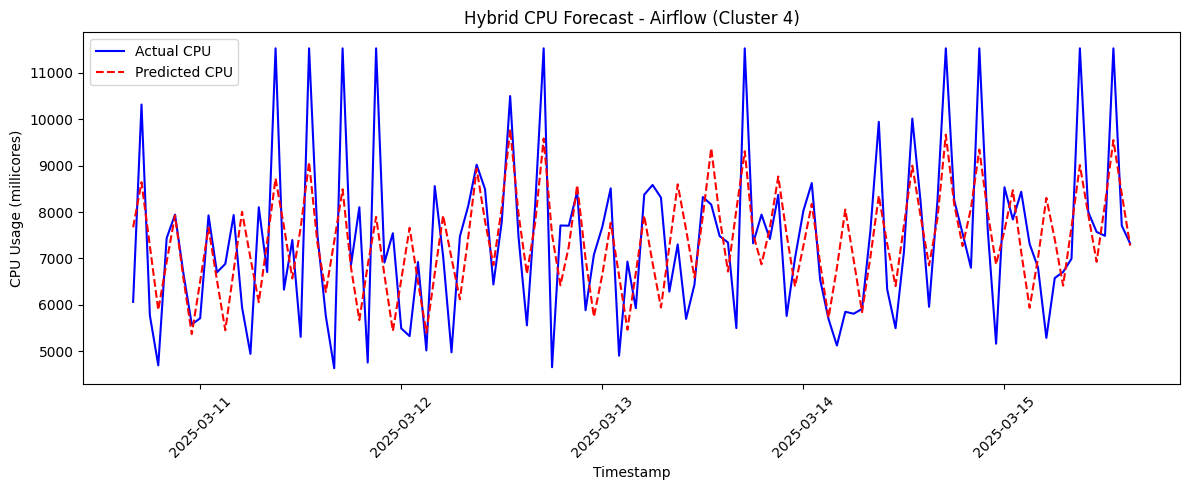

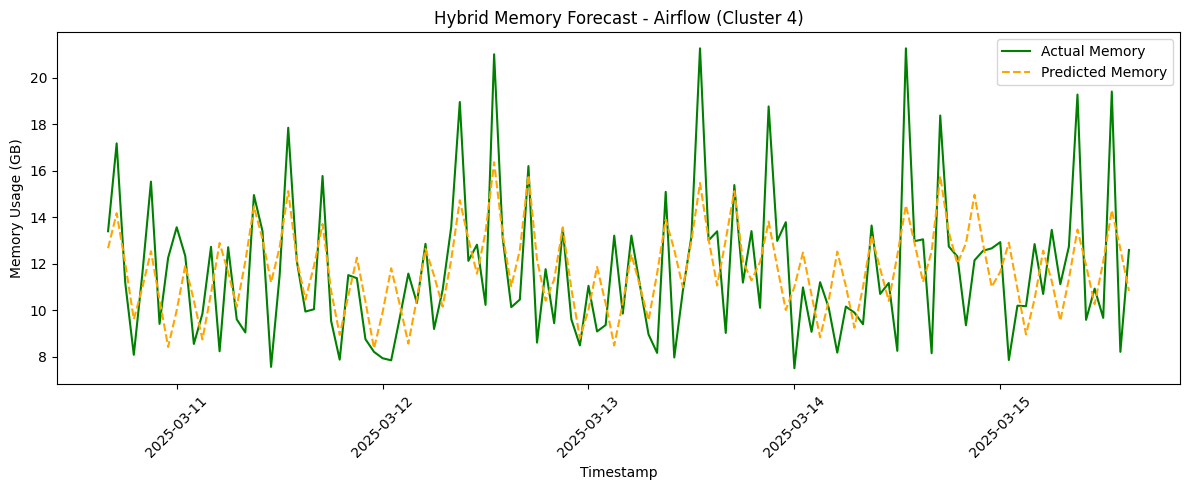


Running Hybrid Forecast for: Dremio (Cluster 4)


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_mo

Epoch 1/50


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.3030 - val_loss: 0.2462
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2325 - val_loss: 0.1658
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1417 - val_loss: 0.0795
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1138 - val_loss: 0.0791
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0825 - val_loss: 0.0572
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0819 - val_loss: 0.0592
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0711 - val_loss: 0.0558
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0738 - val_loss: 0.0564
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0641 - val_loss: 0.0545
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0628 - val_loss: 0.0536
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0616 - val_loss: 0.0546
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0716 - val_loss: 0.0542
Epoch 13/50


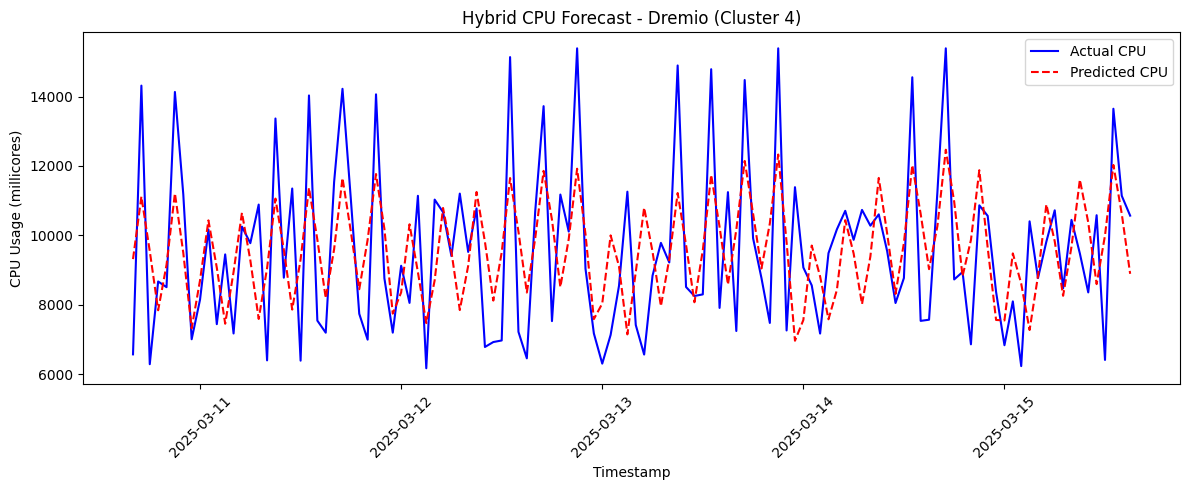

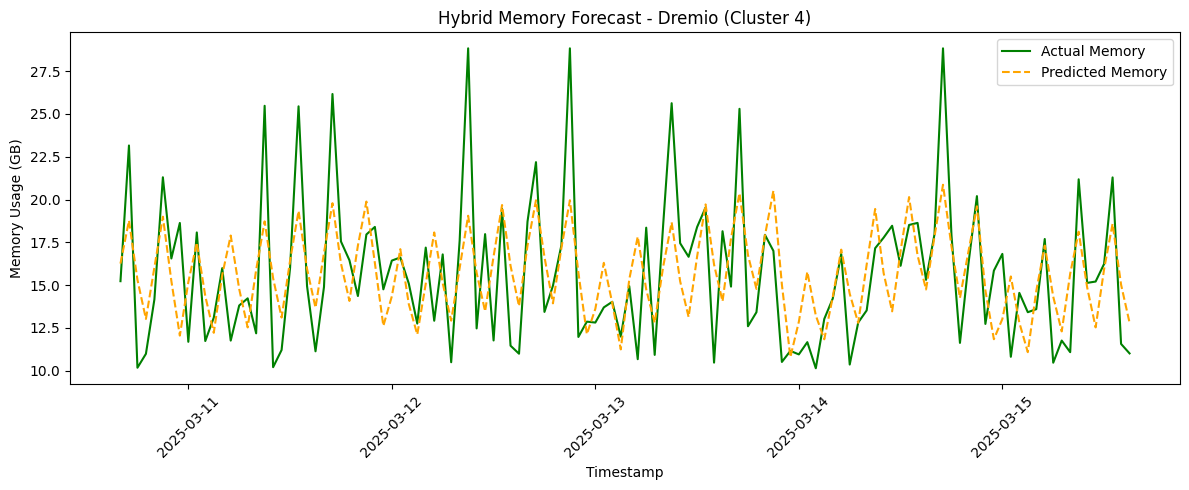


Running Hybrid Forecast for: Metabase (Cluster 4)


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_mo

Epoch 1/50


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.3251 - val_loss: 0.1983
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1921 - val_loss: 0.0743
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0899 - val_loss: 0.0659
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0846 - val_loss: 0.0743
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0954 - val_loss: 0.0608
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0803 - val_loss: 0.0604
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0667 - val_loss: 0.0620
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0714 - val_loss: 0.0600
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0771 - val_loss: 0.0597
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0708 - val_loss: 0.0605
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0819 - val_loss: 0.0601
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0709 - val_loss: 0.0594
Epoch 13/50


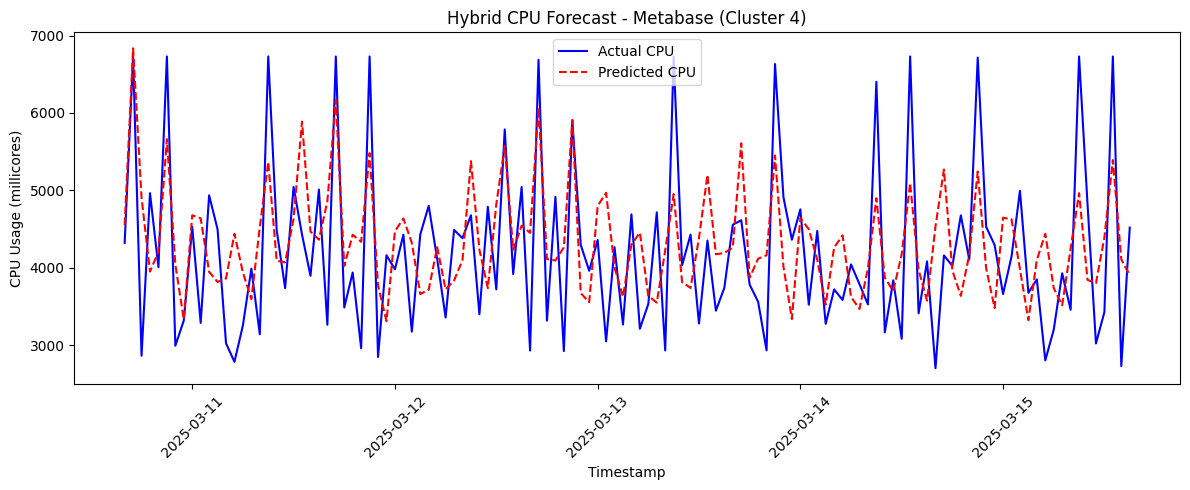

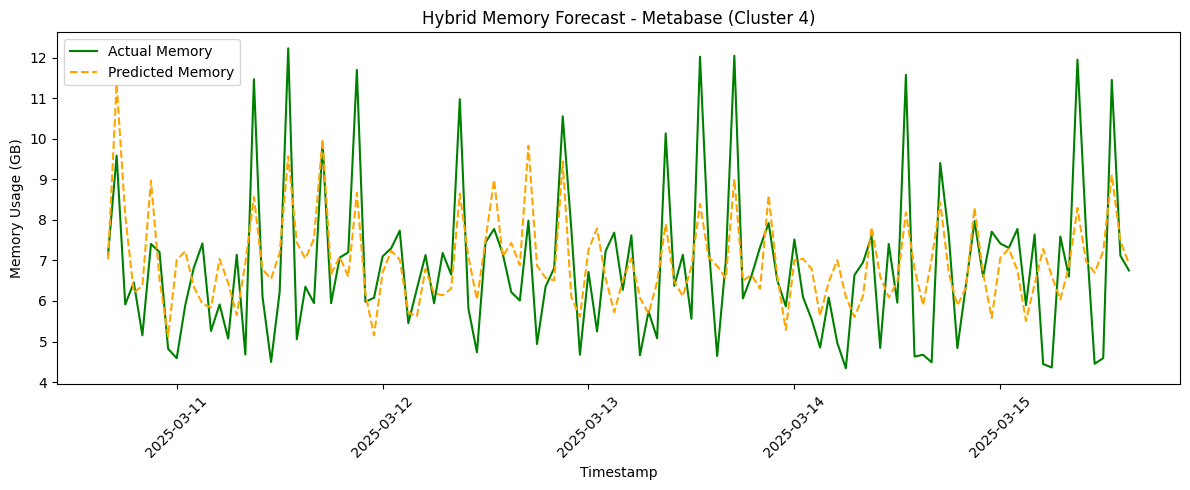


Running Hybrid Forecast for: Prometheus (Cluster 4)


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_mo

Epoch 1/50


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.2561 - val_loss: 0.1137
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1100 - val_loss: 0.0651
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0759 - val_loss: 0.0677
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0845 - val_loss: 0.0643
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0718 - val_loss: 0.0593
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0789 - val_loss: 0.0604
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0689 - val_loss: 0.0592
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0679 - val_loss: 0.0587
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0690 - val_loss: 0.0586
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0647 - val_loss: 0.0583
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0693 - val_loss: 0.0601
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0737 - val_loss: 0.0587
Epoch 13/50


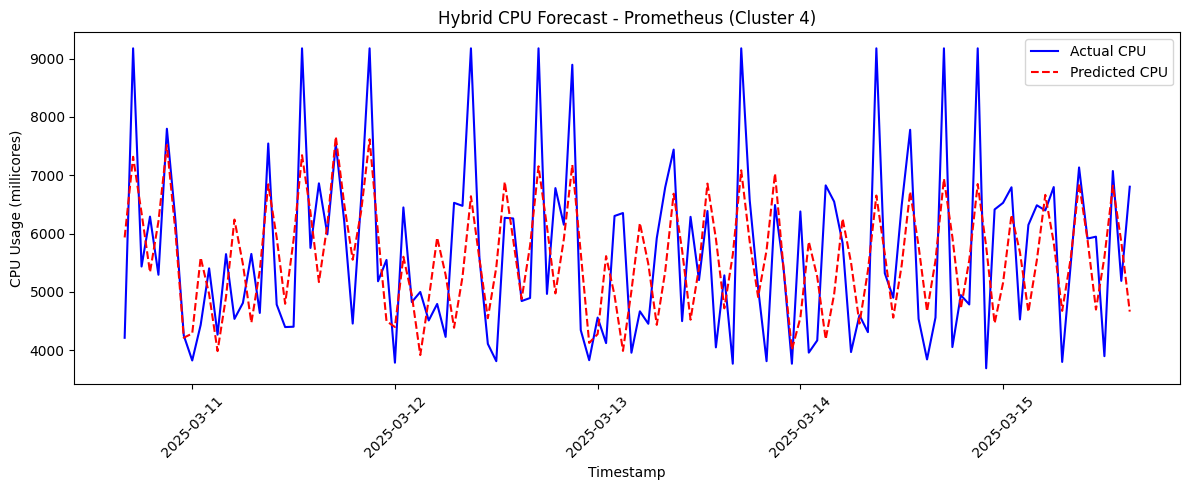

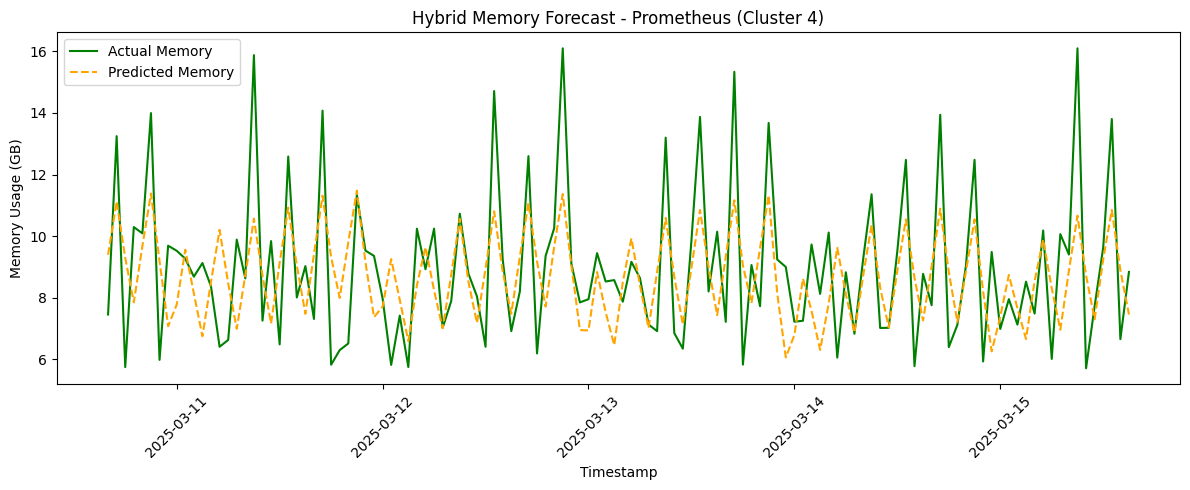


Running Hybrid Forecast for: Superset (Cluster 4)


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

Epoch 1/50


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.2571 - val_loss: 0.1446
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1104 - val_loss: 0.0561
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0759 - val_loss: 0.0546
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0638 - val_loss: 0.0534
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0638 - val_loss: 0.0505
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0603 - val_loss: 0.0531
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0618 - val_loss: 0.0498
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0580 - val_loss: 0.0499
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0501 - val_loss: 0.0478
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0523 - val_loss: 0.0472
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0538 - val_loss: 0.0478
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0527 - val_loss: 0.0459
Epoch 13/50


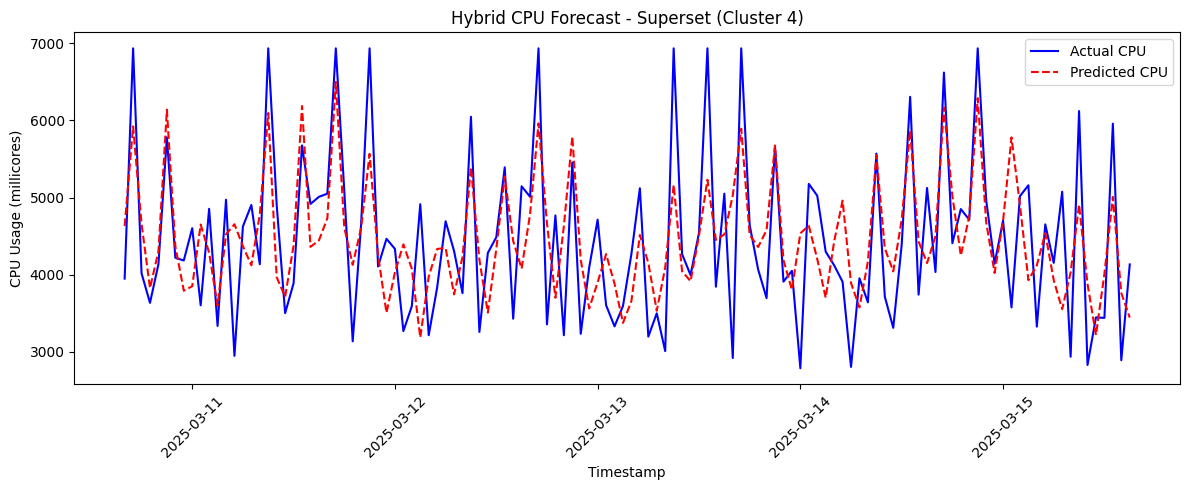

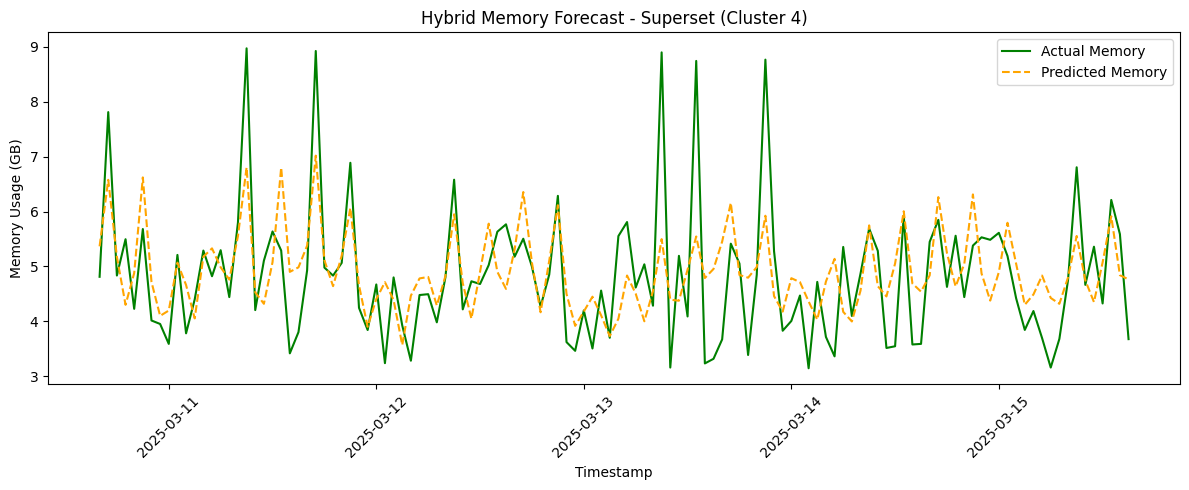


Running Hybrid Forecast for: Tableau Server (Cluster 4)


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_mo

Epoch 1/50


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.3249 - val_loss: 0.1960
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1544 - val_loss: 0.0702
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0922 - val_loss: 0.0700
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0827 - val_loss: 0.0639
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0719 - val_loss: 0.0630
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0800 - val_loss: 0.0618
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0711 - val_loss: 0.0606
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0670 - val_loss: 0.0599
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0641 - val_loss: 0.0595
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0686 - val_loss: 0.0597
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0703 - val_loss: 0.0571
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0691 - val_loss: 0.0596
Epoch 13/50


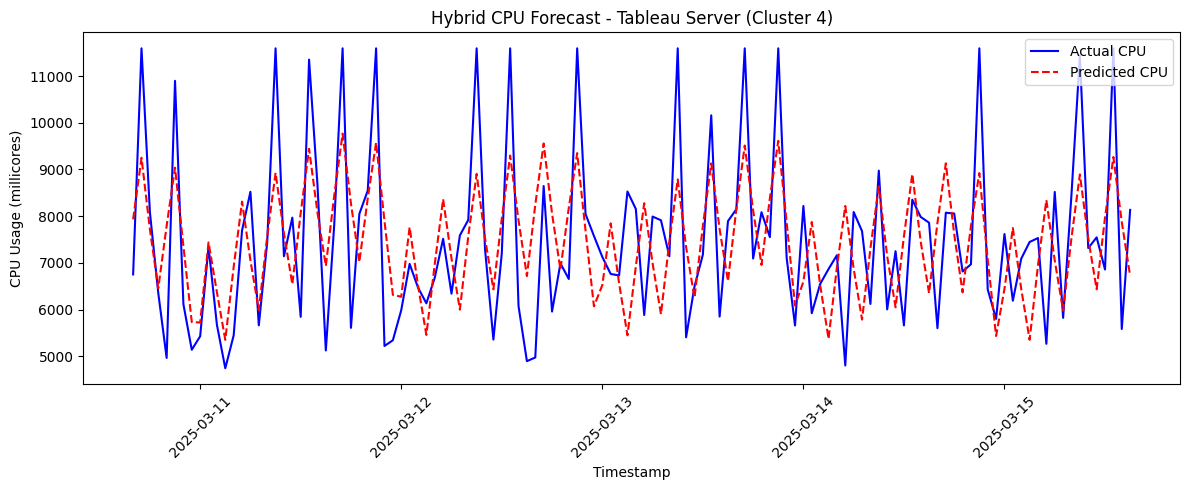

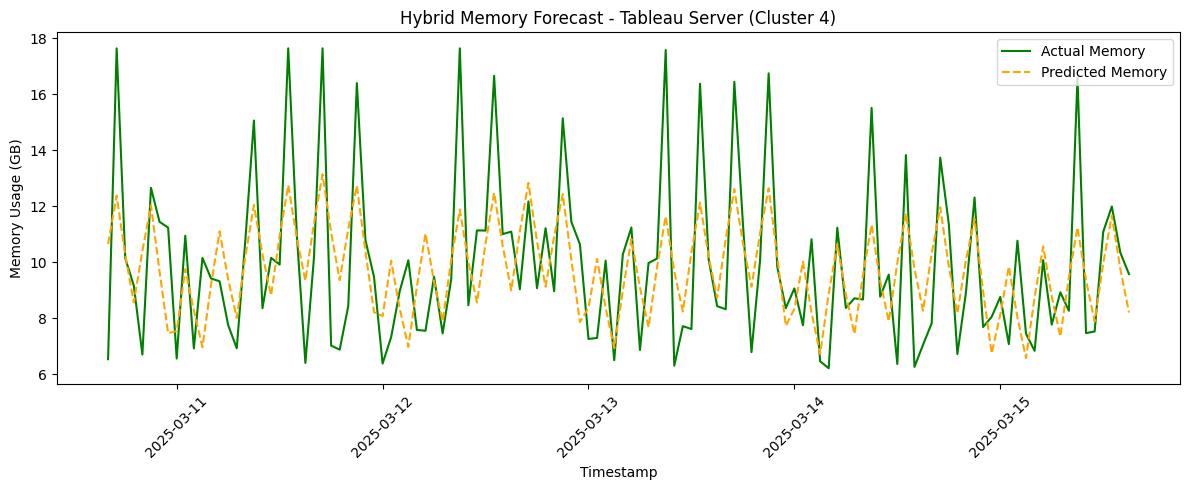


Running Hybrid Forecast for: Trino (Cluster 4)


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

Epoch 1/50


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.2348 - val_loss: 0.1180
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1170 - val_loss: 0.0700
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1005 - val_loss: 0.0815
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0925 - val_loss: 0.0743
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0886 - val_loss: 0.0621
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0737 - val_loss: 0.0613
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0805 - val_loss: 0.0616
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0708 - val_loss: 0.0612
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0739 - val_loss: 0.0608
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0727 - val_loss: 0.0601
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0678 - val_loss: 0.0593
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0688 - val_loss: 0.0595
Epoch 13/50


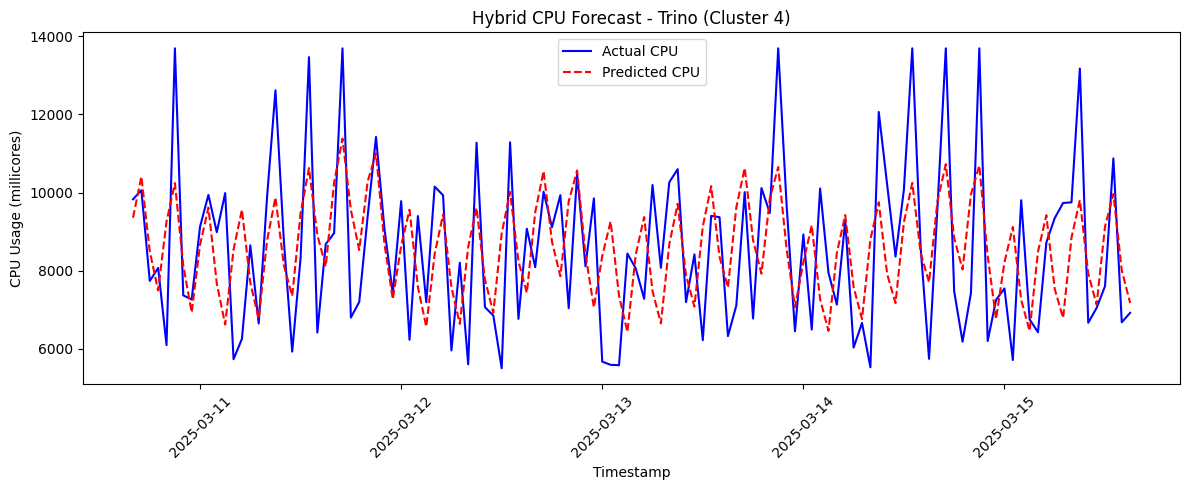

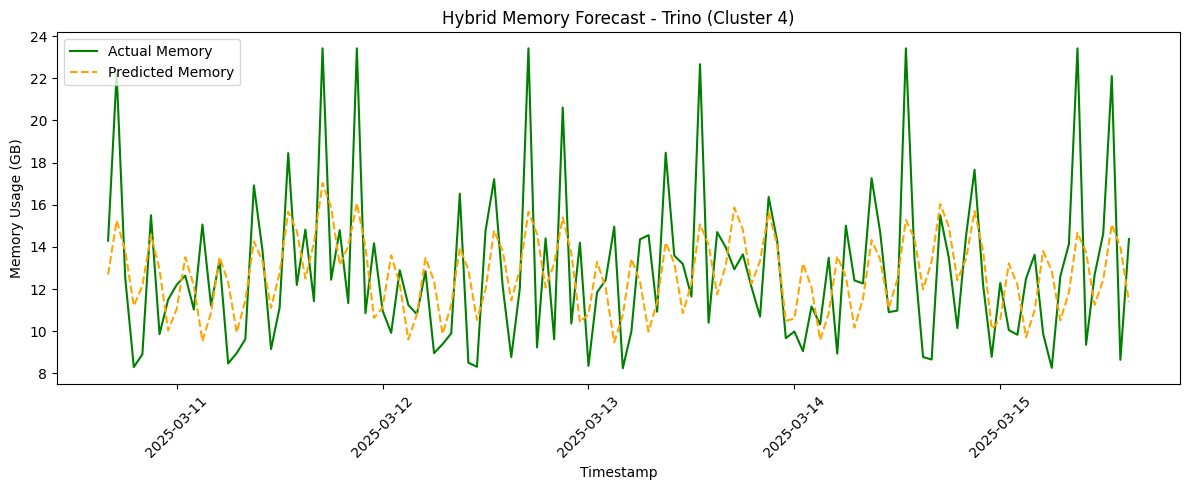

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
df = pd.read_csv("/home/ashken.edirisinghe/Downloads/resampled_application_level.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index("Timestamp", inplace=True)

# Functions
def train_arima(series, order):
    try:
        model = ARIMA(series, order=order)
        model_fit = model.fit()
        return model_fit.forecast(steps=len(test))
    except:
        return None

def create_sequences(data, target_cols, lookback=24):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback].values)
        y.append(data.iloc[i+lookback][target_cols].values)
    return np.array(X), np.array(y)

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / np.maximum(actual, 1e-6))) * 100
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    denominator = np.where(denominator < 1e-6, 1e-6, denominator)
    smape = np.mean(np.abs(actual - predicted) / denominator) * 100
    return mae, rmse, mape, smape

# Select a sample cluster
sample_cluster = df["Cluster ID"].unique()[1]  # Changed to use the second cluster
chart_list = df[df["Cluster ID"] == sample_cluster]["Chart Name"].unique()

for sample_chart in chart_list:
    print(f"\nRunning Hybrid Forecast for: {sample_chart} (Cluster {sample_cluster})")
    
    df_sample = df[(df["Cluster ID"] == sample_cluster) & (df["Chart Name"] == sample_chart)][["CPU Used", "Memory Used (GB)"]].copy()
    if len(df_sample) < 100:
        print("Skipped (insufficient data)")
        continue

    # Normalize full data
    scaler_raw = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler_raw.fit_transform(df_sample), columns=df_sample.columns, index=df_sample.index)
    train_size = int(len(df_scaled) * 0.8)
    train, test = df_scaled[:train_size], df_scaled[train_size:]

    # ARIMA forecast
    cpu_forecast = train_arima(train["CPU Used"], (2, 0, 2))
    memory_forecast = train_arima(train["Memory Used (GB)"], (2, 0, 2))
    if cpu_forecast is None or memory_forecast is None:
        continue

    arima_forecast_df = pd.DataFrame({
        "CPU Used": cpu_forecast,
        "Memory Used (GB)": memory_forecast
    }, index=test.index)

    # Residuals
    cpu_residuals = test["CPU Used"] - arima_forecast_df["CPU Used"]
    memory_residuals = test["Memory Used (GB)"] - arima_forecast_df["Memory Used (GB)"]

    residuals_df = pd.DataFrame({
        "CPU Residuals": cpu_residuals,
        "Memory Residuals": memory_residuals
    }, index=test.index)

    residuals_df["Hour"] = residuals_df.index.hour
    residuals_df["DayOfWeek"] = residuals_df.index.dayofweek
    residuals_df["IsWeekend"] = residuals_df["DayOfWeek"].isin([5, 6]).astype(int)

    # Normalize residuals + time features
    scaler = MinMaxScaler()
    features = ["CPU Residuals", "Memory Residuals", "Hour", "DayOfWeek", "IsWeekend"]
    residuals_scaled = pd.DataFrame(scaler.fit_transform(residuals_df[features]), columns=features, index=residuals_df.index)

    # Sequence creation
    X_train, y_train = create_sequences(residuals_scaled, ["CPU Residuals", "Memory Residuals"], lookback=24)
    X_test, y_test = create_sequences(residuals_scaled, ["CPU Residuals", "Memory Residuals"], lookback=24)

    # LSTM
    lstm_model = build_lstm((24, X_train.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

    # Predict residuals
    residual_pred = lstm_model.predict(X_test)
    residual_pred_rescaled = scaler.inverse_transform(
        np.hstack((residual_pred, np.zeros((residual_pred.shape[0], len(features) - 2))))
    )[:, :2]

    # Final forecast = ARIMA + predicted residuals
    trim_start = len(arima_forecast_df) - len(residual_pred_rescaled)
    cpu_final = arima_forecast_df["CPU Used"].values[trim_start:] + residual_pred_rescaled[:, 0]
    mem_final = arima_forecast_df["Memory Used (GB)"].values[trim_start:] + residual_pred_rescaled[:, 1]

    # Denormalize final values
    cpu_min, cpu_max = df_sample["CPU Used"].min(), df_sample["CPU Used"].max()
    mem_min, mem_max = df_sample["Memory Used (GB)"].min(), df_sample["Memory Used (GB)"].max()

    actual_cpu = test.iloc[trim_start:]["CPU Used"] * (cpu_max - cpu_min) + cpu_min
    actual_mem = test.iloc[trim_start:]["Memory Used (GB)"] * (mem_max - mem_min) + mem_min
    pred_cpu = cpu_final * (cpu_max - cpu_min) + cpu_min
    pred_mem = mem_final * (mem_max - mem_min) + mem_min

    # Print evaluation
    cpu_mae, cpu_rmse, cpu_mape, cpu_smape = evaluate_forecast(actual_cpu, pred_cpu)
    mem_mae, mem_rmse, mem_mape, mem_smape = evaluate_forecast(actual_mem, pred_mem)

    print(f"\nEvaluation for {sample_chart}:")
    print(f"CPU MAE: {cpu_mae:.2f}, RMSE: {cpu_rmse:.2f}, MAPE: {cpu_mape:.2f}%, SMAPE: {cpu_smape:.2f}%")
    print(f"MEM MAE: {mem_mae:.2f}, RMSE: {mem_rmse:.2f}, MAPE: {mem_mape:.2f}%, SMAPE: {mem_smape:.2f}%")

    # Plot CPU forecast
    plt.figure(figsize=(12, 5))
    plt.plot(actual_cpu.index, actual_cpu, label="Actual CPU", color="blue")
    plt.plot(actual_cpu.index, pred_cpu, label="Predicted CPU", color="red", linestyle="--")
    plt.title(f"Hybrid CPU Forecast - {sample_chart} (Cluster {sample_cluster})")
    plt.xlabel("Timestamp")
    plt.ylabel("CPU Usage (millicores)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot Memory forecast
    plt.figure(figsize=(12, 5))
    plt.plot(actual_mem.index, actual_mem, label="Actual Memory", color="green")
    plt.plot(actual_mem.index, pred_mem, label="Predicted Memory", color="orange", linestyle="--")
    plt.title(f"Hybrid Memory Forecast - {sample_chart} (Cluster {sample_cluster})")
    plt.xlabel("Timestamp")
    plt.ylabel("Memory Usage (GB)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Selected Cluster: 2, Selected Chart: CockroachDB


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_mo


 Tuning over 72 combinations...

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}
Validation Loss (MSE): 0.04607

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05302

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04733

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05107

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.15980

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04710

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.3, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04574

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.3, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05516

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.3, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04649

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.3, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04729

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.3, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.17956

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.3, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05656

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04441

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05477

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04389

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04921

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.09289

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04504

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.2, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04470

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.2, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05262

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.2, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04551

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.2, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04756

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.2, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05816

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.2, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04810

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04625

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05255

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04850

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04742

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05453

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.10734

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04427

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05202

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04834

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.15, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04849

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.15, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05916

 Trying params: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.15, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.13253

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04531

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05437

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04314

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04517

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.07452

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04841

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.3, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04539

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.3, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05129

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.3, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04771

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.3, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04618

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.3, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.06376

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.3, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04465

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04383

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05152

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04010

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04862

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.06189

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04879

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.2, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04328

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.2, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05089

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.2, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04382

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.2, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04688

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.2, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05390

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.2, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04656

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04398

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05174

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04858

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04569

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05686

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.12330

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04437

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05208

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04511

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.15, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.04514

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.15, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.0001, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.05460

 Trying params: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate': 0.15, 'batch_size': 32, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss (MSE): 0.11216

 Best Params: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.15, 'batch_size': 16, 'lookback': 24, 'learning_rate': 0.01, 'activation_fn': 'relu', 'optimizer': 'adam', 'num_epochs': 30, 'patience': 5}
 Best Validation Loss: 0.04010
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f1a05ace710> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/p

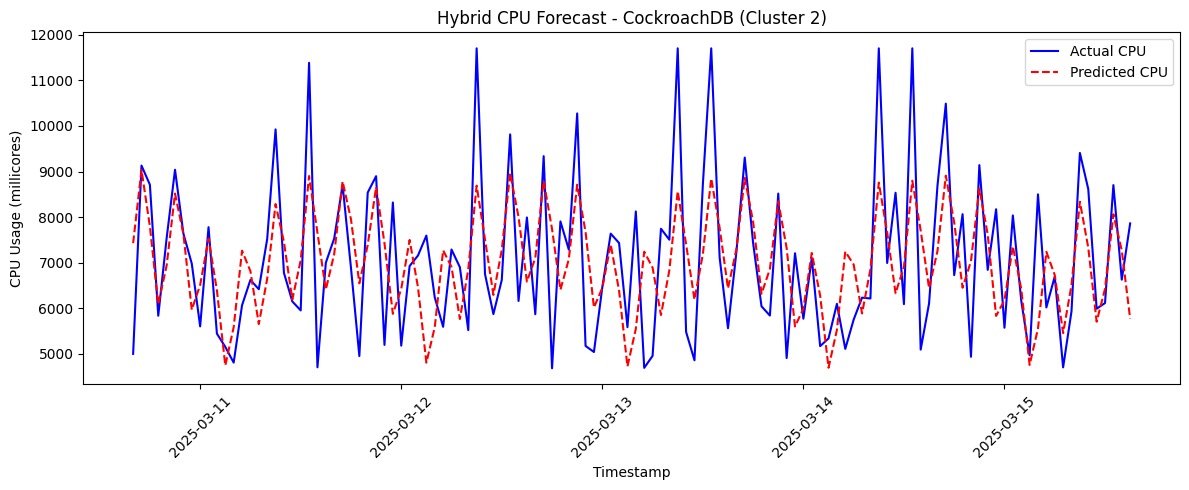

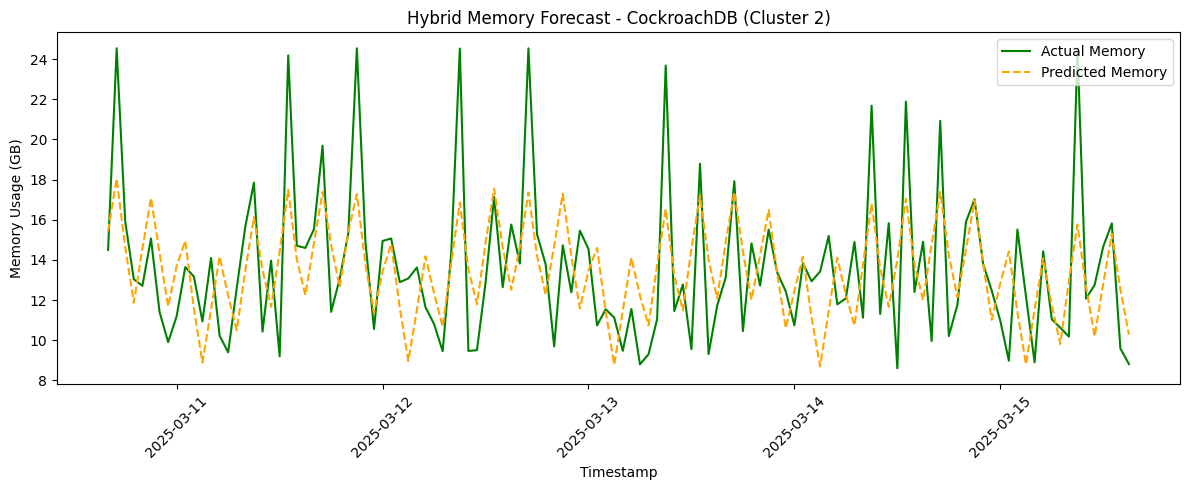

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from itertools import product

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
df = pd.read_csv("/home/ashken.edirisinghe/Downloads/resampled_application_level.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index("Timestamp", inplace=True)

# Select a cluster and chart
sample_cluster = df["Cluster ID"].unique()[0]
sample_chart = df[df["Cluster ID"] == sample_cluster]["Chart Name"].unique()[0]
print(f"Selected Cluster: {sample_cluster}, Selected Chart: {sample_chart}")

# Filter and normalize data
df_sample = df[(df["Cluster ID"] == sample_cluster) & (df["Chart Name"] == sample_chart)][["CPU Used", "Memory Used (GB)"]].copy()
scaler_raw = MinMaxScaler()
df_scaled = pd.DataFrame(scaler_raw.fit_transform(df_sample), columns=df_sample.columns, index=df_sample.index)

# Train-test split
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Train ARIMA
def train_arima(series, order):
    try:
        model = ARIMA(series, order=order)
        model_fit = model.fit()
        return model_fit.forecast(steps=len(test))
    except Exception as e:
        print(f"ARIMA failed: {e}")
        return None

cpu_forecast = train_arima(train["CPU Used"], (2, 0, 2))
memory_forecast = train_arima(train["Memory Used (GB)"], (2, 0, 2))
if cpu_forecast is None or memory_forecast is None:
    raise ValueError("ARIMA model training failed.")

arima_forecast_df = pd.DataFrame({
    "CPU Used": cpu_forecast,
    "Memory Used (GB)": memory_forecast
}, index=test.index)

# Compute residuals
cpu_residuals = test["CPU Used"] - arima_forecast_df["CPU Used"]
memory_residuals = test["Memory Used (GB)"] - arima_forecast_df["Memory Used (GB)"]

residuals_df = pd.DataFrame({
    "CPU Residuals": cpu_residuals,
    "Memory Residuals": memory_residuals
}, index=test.index)
residuals_df["Hour"] = residuals_df.index.hour
residuals_df["DayOfWeek"] = residuals_df.index.dayofweek
residuals_df["IsWeekend"] = residuals_df["DayOfWeek"].isin([5, 6]).astype(int)

# Normalize residual features
scaler = MinMaxScaler()
features = ["CPU Residuals", "Memory Residuals", "Hour", "DayOfWeek", "IsWeekend"]
residuals_scaled = pd.DataFrame(scaler.fit_transform(residuals_df[features]), columns=features, index=residuals_df.index)

# Sequence creator
def create_sequences(data, target_cols, lookback=24):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback].values)
        y.append(data.iloc[i+lookback][target_cols].values)
    return np.array(X), np.array(y)

# Hyperparameter grid
param_grid = {
    'lstm_units_1': [32, 64],
    'lstm_units_2': [32, 64],
    'dropout_rate': [0.2, 0.3, 0.15],
    'batch_size': [16, 32],
    'lookback': [24],
    'learning_rate': [0.001, 0.0001, 0.01],
    'activation_fn': ['relu'],
    'optimizer': ['adam'],
    'num_epochs': [30],
    'patience': [5]
}

# Grid search
best_model, best_params, best_score = None, None, float('inf')
param_names = list(param_grid.keys())
combinations = list(product(*param_grid.values()))
print(f"\n Tuning over {len(combinations)} combinations...")

for combo in combinations:
    params = dict(zip(param_names, combo))
    print(f"\n Trying params: {params}")
    try:
        X_train, y_train = create_sequences(residuals_scaled, ["CPU Residuals", "Memory Residuals"], params['lookback'])
        X_test, y_test = create_sequences(residuals_scaled, ["CPU Residuals", "Memory Residuals"], params['lookback'])

        # Build model
        optimizer = Adam(learning_rate=params['learning_rate']) if params['optimizer'] == 'adam' else RMSprop(learning_rate=params['learning_rate'])
        model = Sequential([
            LSTM(params['lstm_units_1'], activation=params['activation_fn'], return_sequences=True, input_shape=(params['lookback'], X_train.shape[2])),
            Dropout(params['dropout_rate']),
            LSTM(params['lstm_units_2'], activation=params['activation_fn']),
            Dropout(params['dropout_rate']),
            Dense(2)
        ])
        model.compile(optimizer=optimizer, loss='mse')
        early_stopping = EarlyStopping(monitor='val_loss', patience=params['patience'], restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs=params['num_epochs'], batch_size=params['batch_size'],
                            validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

        val_loss = model.evaluate(X_test, y_test, verbose=0)
        print(f"Validation Loss (MSE): {val_loss:.5f}")

        if val_loss < best_score:
            best_score = val_loss
            best_model = model
            best_params = params
            best_X_test = X_test
            best_y_test = y_test
    except Exception as e:
        print(f" Skipping due to error: {e}")
        continue

print(f"\n Best Params: {best_params}")
print(f" Best Validation Loss: {best_score:.5f}")

# Predict residuals using best model
residual_pred = best_model.predict(best_X_test)
residual_pred_rescaled = scaler.inverse_transform(
    np.hstack((residual_pred, np.zeros((residual_pred.shape[0], len(features) - 2))))
)[:, :2]

# Combine with ARIMA forecast
trim_start = len(arima_forecast_df) - len(residual_pred_rescaled)
cpu_final = arima_forecast_df["CPU Used"].values[trim_start:] + residual_pred_rescaled[:, 0]
mem_final = arima_forecast_df["Memory Used (GB)"].values[trim_start:] + residual_pred_rescaled[:, 1]

# Denormalize
cpu_min, cpu_max = df_sample["CPU Used"].min(), df_sample["CPU Used"].max()
mem_min, mem_max = df_sample["Memory Used (GB)"].min(), df_sample["Memory Used (GB)"].max()
actual_cpu = test.iloc[trim_start:]["CPU Used"] * (cpu_max - cpu_min) + cpu_min
actual_mem = test.iloc[trim_start:]["Memory Used (GB)"] * (mem_max - mem_min) + mem_min
pred_cpu = cpu_final * (cpu_max - cpu_min) + cpu_min
pred_mem = mem_final * (mem_max - mem_min) + mem_min

# Print samples
test_samples = pd.DataFrame({
    "Actual CPU (millicores)": actual_cpu.sample(10, random_state=42).values,
    "Predicted CPU (millicores)": pred_cpu[:10],
    "Actual Memory (GB)": actual_mem.sample(10, random_state=42).values,
    "Predicted Memory (GB)": pred_mem[:10]
})
print("\n 10 Random Test Samples (Denormalized):")
print(test_samples)

# Plot CPU
plt.figure(figsize=(12, 5))
plt.plot(actual_cpu.index, actual_cpu, label="Actual CPU", color="blue")
plt.plot(actual_cpu.index, pred_cpu, label="Predicted CPU", color="red", linestyle="--")
plt.title(f"Hybrid CPU Forecast - {sample_chart} (Cluster {sample_cluster})")
plt.xlabel("Timestamp")
plt.ylabel("CPU Usage (millicores)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Memory
plt.figure(figsize=(12, 5))
plt.plot(actual_mem.index, actual_mem, label="Actual Memory", color="green")
plt.plot(actual_mem.index, pred_mem, label="Predicted Memory", color="orange", linestyle="--")
plt.title(f"Hybrid Memory Forecast - {sample_chart} (Cluster {sample_cluster})")
plt.xlabel("Timestamp")
plt.ylabel("Memory Usage (GB)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


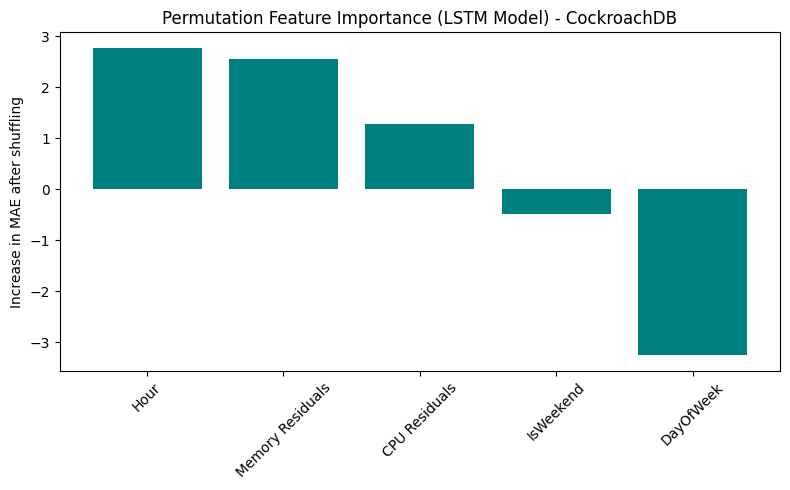

In [30]:
import copy

def permutation_importance_lstm(model, X, y, metric_fn=mean_absolute_error):
    baseline_preds = model.predict(X)
    baseline_error = metric_fn(y, baseline_preds)

    importances = {}
    for i, col in enumerate(residuals_scaled.columns):
        X_permuted = copy.deepcopy(X)
        original_col = X_permuted[:, :, i].copy()
        np.random.shuffle(X_permuted[:, :, i])
        shuffled_preds = model.predict(X_permuted)
        error = metric_fn(y, shuffled_preds)
        importances[col] = error - baseline_error  # increase in error
        X_permuted[:, :, i] = original_col  # restore

    return importances

# Run permutation importance
importances = permutation_importance_lstm(lstm_model, X_test, y_test)
importances = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(8, 5))
plt.bar(importances.keys(), importances.values(), color='teal')
plt.title(f"Permutation Feature Importance (LSTM Model) - {sample_chart}")
plt.ylabel("Increase in MAE after shuffling")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Running LSTM Forecast for: Airflow (Cluster 4)
Epoch 1/50


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1334 - val_loss: 0.0609
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0717 - val_loss: 0.0610
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0700 - val_loss: 0.0592
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0679 - val_loss: 0.0578
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0678 - val_loss: 0.0560
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0663 - val_loss: 0.0494
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0533 - val_loss: 0.0384
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0450 - val_loss: 0.0412
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0489 - val_loss: 0.0333
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0465 - val_loss: 0.0344
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0389 - val_loss: 0.0330
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0395 - val_l

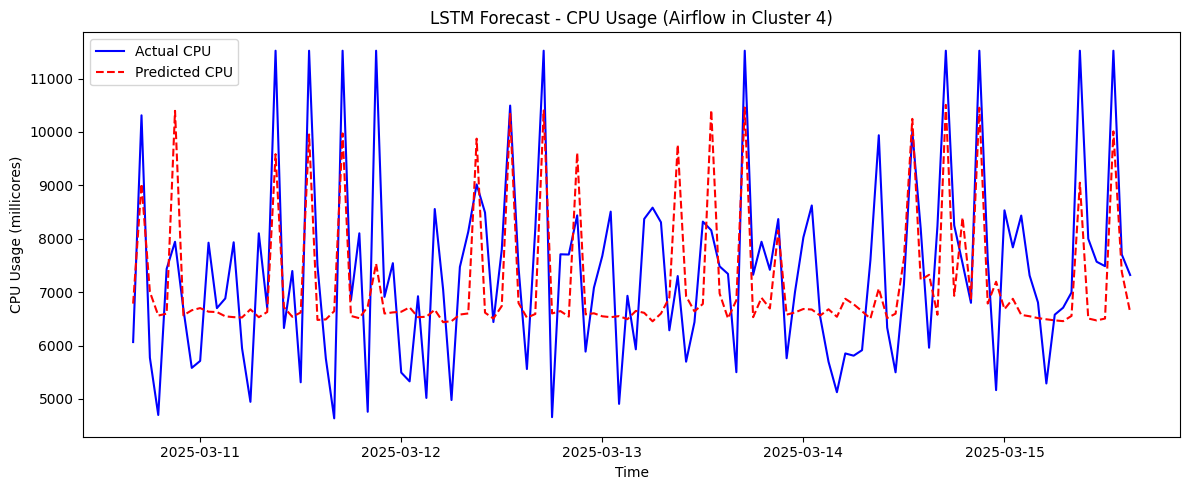

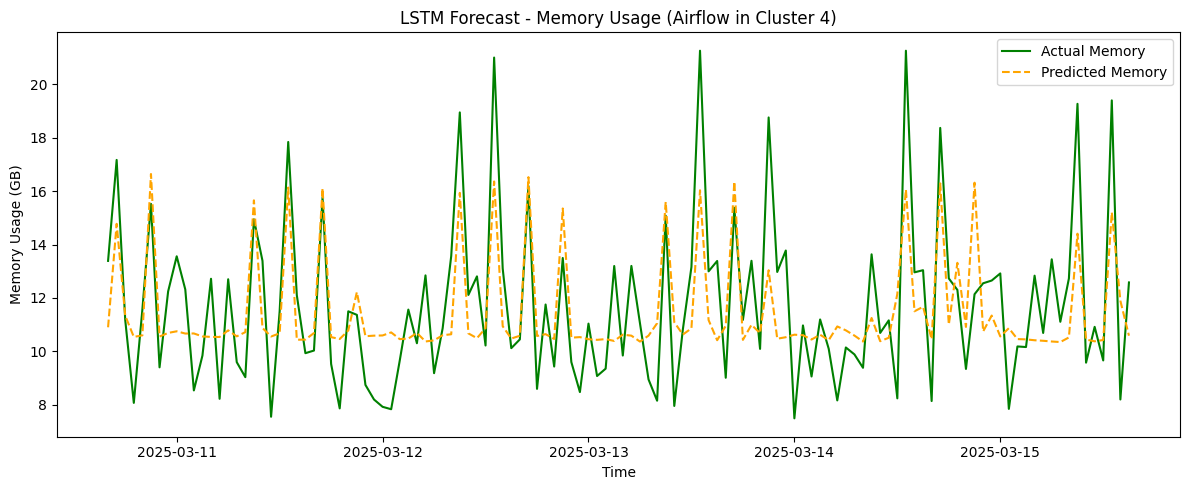


🔹 Sample 10 Predictions vs Actuals
2025-03-12 12:00:00 | Actual CPU: 7796.77, Predicted CPU: 6741.10, Actual Mem: 10.22, Predicted Mem: 10.87
2025-03-12 15:00:00 | Actual CPU: 5560.56, Predicted CPU: 6522.71, Actual Mem: 10.12, Predicted Mem: 10.48
2025-03-10 20:00:00 | Actual CPU: 7436.02, Predicted CPU: 6597.63, Actual Mem: 11.57, Predicted Mem: 10.60
2025-03-12 23:00:00 | Actual CPU: 7084.59, Predicted CPU: 6604.53, Actual Mem: 8.48, Predicted Mem: 10.54
2025-03-11 18:00:00 | Actual CPU: 6853.40, Predicted CPU: 6554.71, Actual Mem: 9.53, Predicted Mem: 10.53
2025-03-13 08:00:00 | Actual CPU: 6286.39, Predicted CPU: 6898.70, Actual Mem: 8.16, Predicted Mem: 11.06
2025-03-13 17:00:00 | Actual CPU: 11522.33, Predicted CPU: 10458.56, Actual Mem: 15.37, Predicted Mem: 16.36
2025-03-11 02:00:00 | Actual CPU: 6701.26, Predicted CPU: 6628.01, Actual Mem: 8.54, Predicted Mem: 10.67
2025-03-12 08:00:00 | Actual CPU: 8132.98, Predicted CPU: 6601.88, Actual Mem: 13.57, Predicted Mem: 10.64
202

/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1341 - val_loss: 0.0634
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0769 - val_loss: 0.0641
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0744 - val_loss: 0.0632
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0730 - val_loss: 0.0615
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0690 - val_loss: 0.0578
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0654 - val_loss: 0.0447
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0625 - val_loss: 0.0560
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0644 - val_loss: 0.0435
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0560 - val_loss: 0.0527
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0582 - val_loss: 0.0441
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0445 - val_loss: 0.0391
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0417 - val_l

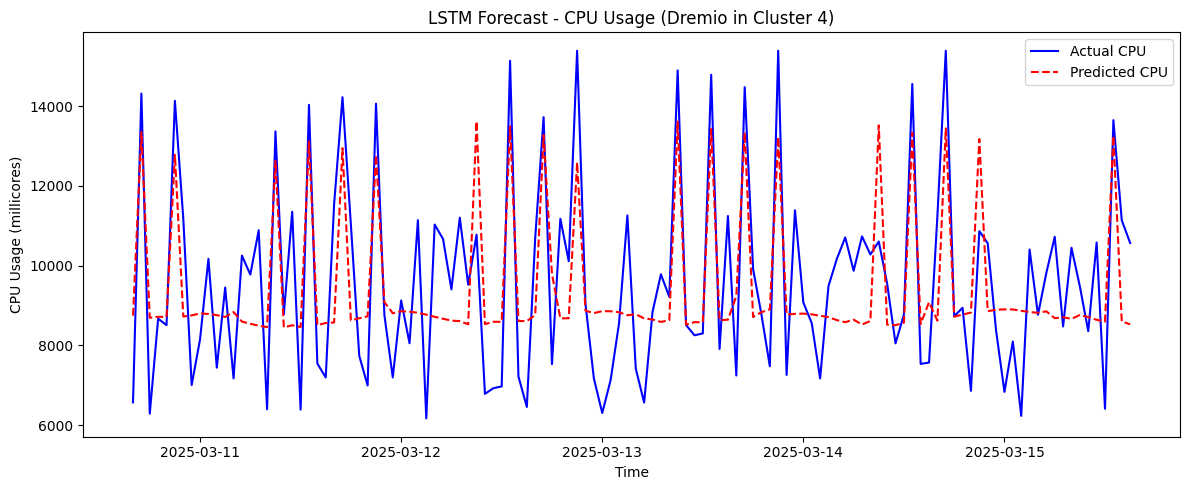

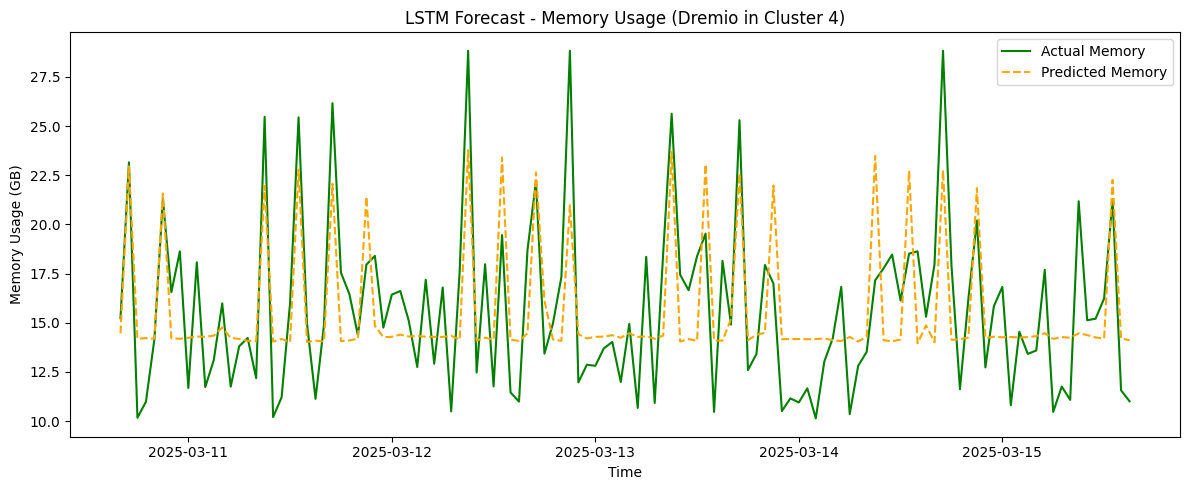


🔹 Sample 10 Predictions vs Actuals
2025-03-14 08:00:00 | Actual CPU: 10278.77, Predicted CPU: 8612.72, Actual Mem: 13.52, Predicted Mem: 14.29
2025-03-12 16:00:00 | Actual CPU: 10691.85, Predicted CPU: 8760.88, Actual Mem: 18.71, Predicted Mem: 14.46
2025-03-11 07:00:00 | Actual CPU: 10886.70, Predicted CPU: 8493.79, Actual Mem: 14.22, Predicted Mem: 14.08
2025-03-11 09:00:00 | Actual CPU: 13367.47, Predicted CPU: 12622.47, Actual Mem: 25.48, Predicted Mem: 21.97
2025-03-12 17:00:00 | Actual CPU: 13723.33, Predicted CPU: 13272.82, Actual Mem: 22.18, Predicted Mem: 22.65
2025-03-14 00:00:00 | Actual CPU: 9072.86, Predicted CPU: 8796.51, Actual Mem: 10.95, Predicted Mem: 14.17
2025-03-14 17:00:00 | Actual CPU: 15390.00, Predicted CPU: 13441.55, Actual Mem: 28.84, Predicted Mem: 22.76
2025-03-11 17:00:00 | Actual CPU: 14223.49, Predicted CPU: 12943.85, Actual Mem: 26.17, Predicted Mem: 22.07
2025-03-13 04:00:00 | Actual CPU: 7416.07, Predicted CPU: 8780.34, Actual Mem: 14.94, Predicted M

/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1317 - val_loss: 0.0672
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0719 - val_loss: 0.0680
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0723 - val_loss: 0.0659
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0721 - val_loss: 0.0665
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0683 - val_loss: 0.0646
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0654 - val_loss: 0.0649
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0661 - val_loss: 0.0631
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0633 - val_loss: 0.0644
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0649 - val_loss: 0.0634
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0673 - val_loss: 0.0626
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0645 - val_loss: 0.0622
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0625 - val_l

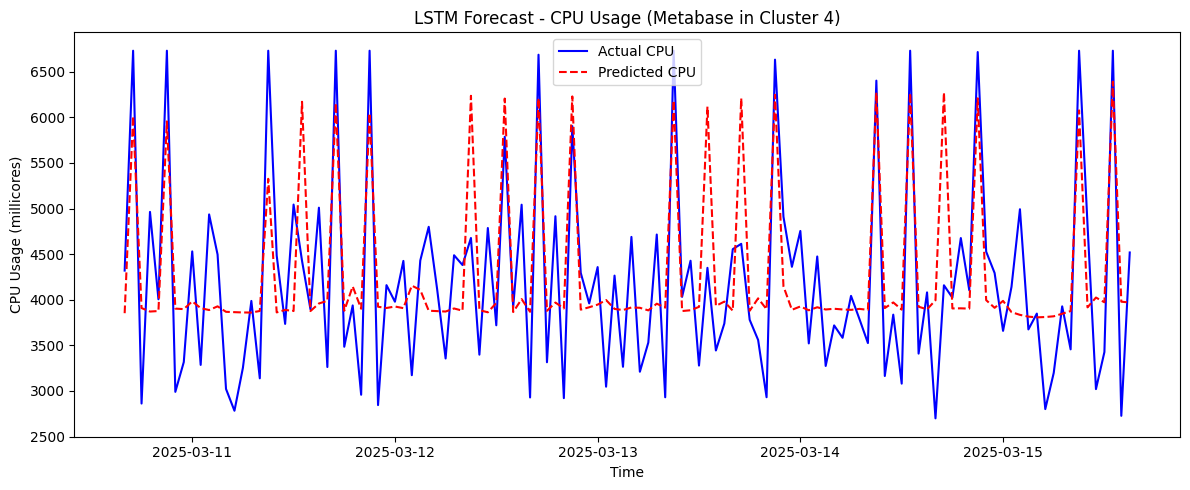

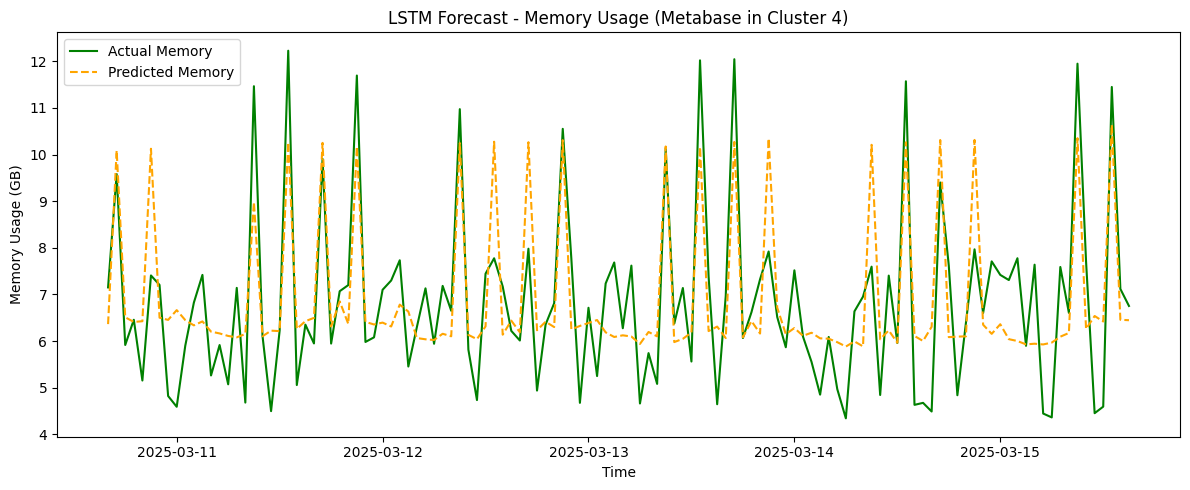


🔹 Sample 10 Predictions vs Actuals
2025-03-14 03:00:00 | Actual CPU: 3274.09, Predicted CPU: 3892.74, Actual Mem: 4.85, Predicted Mem: 6.06
2025-03-13 07:00:00 | Actual CPU: 4714.70, Predicted CPU: 3956.45, Actual Mem: 5.74, Predicted Mem: 6.19
2025-03-11 01:00:00 | Actual CPU: 3285.43, Predicted CPU: 3908.17, Actual Mem: 5.90, Predicted Mem: 6.45
2025-03-11 04:00:00 | Actual CPU: 3021.78, Predicted CPU: 3867.29, Actual Mem: 5.26, Predicted Mem: 6.20
2025-03-13 04:00:00 | Actual CPU: 4688.52, Predicted CPU: 3915.18, Actual Mem: 6.27, Predicted Mem: 6.12
2025-03-14 13:00:00 | Actual CPU: 6729.83, Predicted CPU: 6264.67, Actual Mem: 11.57, Predicted Mem: 10.26
2025-03-13 05:00:00 | Actual CPU: 3210.27, Predicted CPU: 3911.44, Actual Mem: 7.62, Predicted Mem: 6.10
2025-03-13 11:00:00 | Actual CPU: 4427.22, Predicted CPU: 3884.42, Actual Mem: 7.14, Predicted Mem: 6.05
2025-03-11 17:00:00 | Actual CPU: 6729.83, Predicted CPU: 6155.67, Actual Mem: 9.91, Predicted Mem: 10.25
2025-03-12 10:00

/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1684 - val_loss: 0.0678
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0829 - val_loss: 0.0666
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0804 - val_loss: 0.0657
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0780 - val_loss: 0.0650
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0767 - val_loss: 0.0644
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0767 - val_loss: 0.0637
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0725 - val_loss: 0.0633
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0746 - val_loss: 0.0616
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0698 - val_loss: 0.0599
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0682 - val_loss: 0.0533
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0619 - val_loss: 0.0715
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0819 - val_l

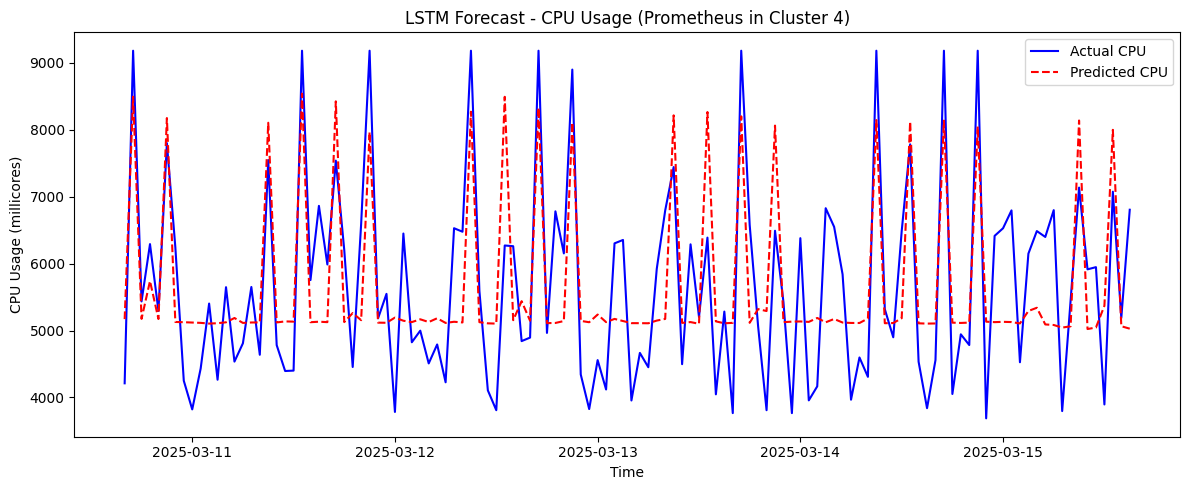

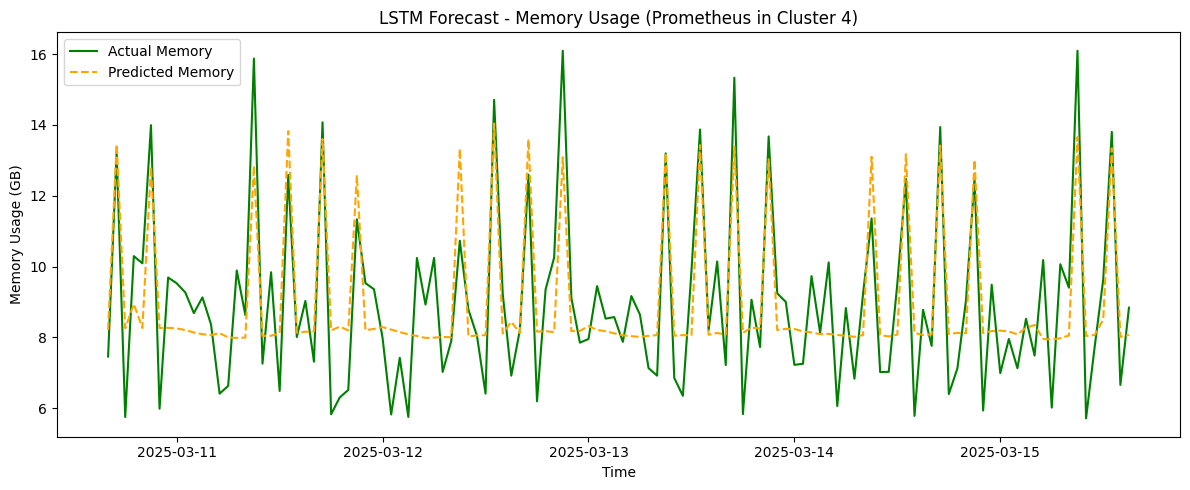


🔹 Sample 10 Predictions vs Actuals
2025-03-13 15:00:00 | Actual CPU: 5282.47, Predicted CPU: 5107.50, Actual Mem: 10.14, Predicted Mem: 8.12
2025-03-14 21:00:00 | Actual CPU: 9178.17, Predicted CPU: 8045.90, Actual Mem: 12.48, Predicted Mem: 13.01
2025-03-11 02:00:00 | Actual CPU: 5402.48, Predicted CPU: 5103.59, Actual Mem: 8.68, Predicted Mem: 8.13
2025-03-13 22:00:00 | Actual CPU: 5423.52, Predicted CPU: 5124.62, Actual Mem: 9.24, Predicted Mem: 8.21
2025-03-14 11:00:00 | Actual CPU: 4898.79, Predicted CPU: 5111.72, Actual Mem: 7.02, Predicted Mem: 8.02
2025-03-15 02:00:00 | Actual CPU: 4525.97, Predicted CPU: 5105.91, Actual Mem: 7.13, Predicted Mem: 8.08
2025-03-14 02:00:00 | Actual CPU: 4166.23, Predicted CPU: 5187.25, Actual Mem: 9.73, Predicted Mem: 8.14
2025-03-12 05:00:00 | Actual CPU: 4791.50, Predicted CPU: 5182.93, Actual Mem: 8.93, Predicted Mem: 7.98
2025-03-13 16:00:00 | Actual CPU: 3766.48, Predicted CPU: 5114.67, Actual Mem: 7.22, Predicted Mem: 8.08
2025-03-13 21:00

/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1156 - val_loss: 0.0599
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0800 - val_loss: 0.0572
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0746 - val_loss: 0.0574
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0751 - val_loss: 0.0580
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0731 - val_loss: 0.0602
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0733 - val_loss: 0.0584
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0731 - val_loss: 0.0543
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0649 - val_loss: 0.0426
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0629 - val_loss: 0.0528
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0611 - val_loss: 0.0426
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0460 - val_loss: 0.0392
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0449 - val_l

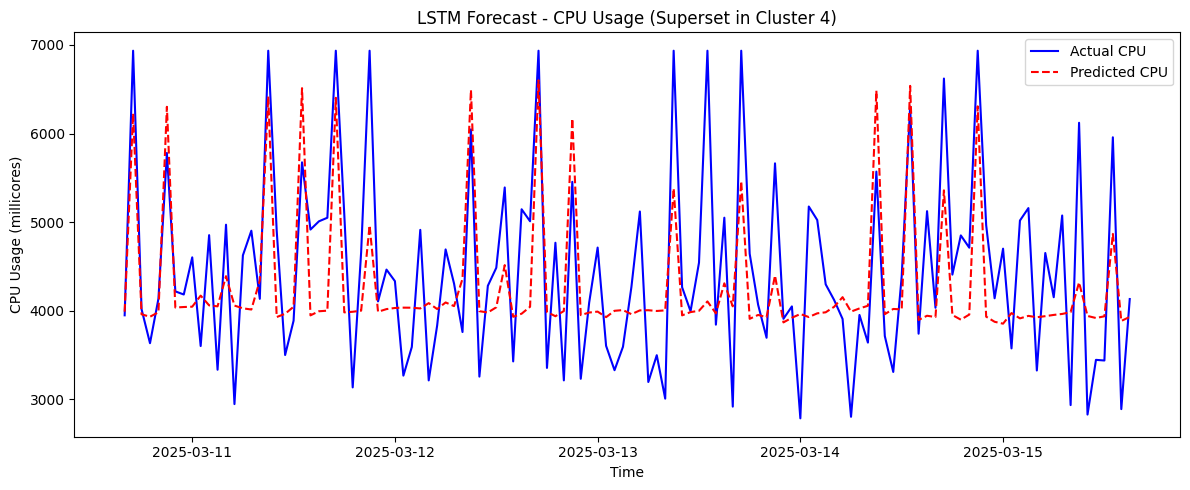

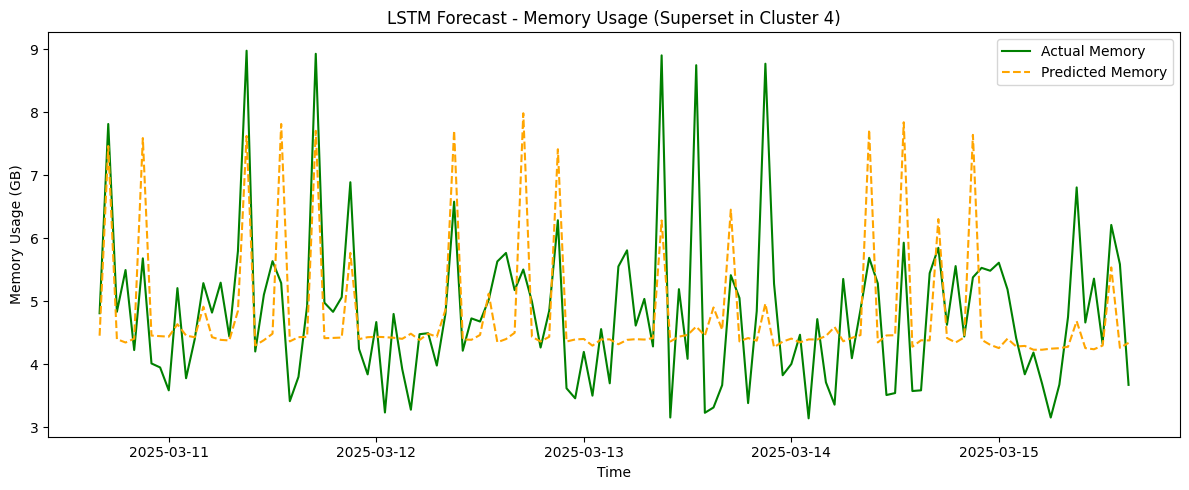


🔹 Sample 10 Predictions vs Actuals
2025-03-13 09:00:00 | Actual CPU: 6934.33, Predicted CPU: 5380.98, Actual Mem: 8.90, Predicted Mem: 6.28
2025-03-13 15:00:00 | Actual CPU: 5050.74, Predicted CPU: 4310.36, Actual Mem: 3.32, Predicted Mem: 4.90
2025-03-15 01:00:00 | Actual CPU: 3576.26, Predicted CPU: 3974.83, Actual Mem: 5.19, Predicted Mem: 4.41
2025-03-13 00:00:00 | Actual CPU: 4713.67, Predicted CPU: 3991.37, Actual Mem: 4.20, Predicted Mem: 4.40
2025-03-10 21:00:00 | Actual CPU: 5780.88, Predicted CPU: 6301.58, Actual Mem: 5.68, Predicted Mem: 7.59
2025-03-12 14:00:00 | Actual CPU: 3429.50, Predicted CPU: 3932.66, Actual Mem: 5.63, Predicted Mem: 4.35
2025-03-13 17:00:00 | Actual CPU: 6934.33, Predicted CPU: 5460.60, Actual Mem: 5.42, Predicted Mem: 6.45
2025-03-11 06:00:00 | Actual CPU: 4626.25, Predicted CPU: 4028.71, Actual Mem: 5.30, Predicted Mem: 4.39
2025-03-14 15:00:00 | Actual CPU: 5124.47, Predicted CPU: 3944.60, Actual Mem: 3.59, Predicted Mem: 4.38
2025-03-12 16:00:00

/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1295 - val_loss: 0.0772
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0757 - val_loss: 0.0746
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0765 - val_loss: 0.0741
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0720 - val_loss: 0.0733
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0713 - val_loss: 0.0731
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0691 - val_loss: 0.0731
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0716 - val_loss: 0.0721
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0696 - val_loss: 0.0694
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0675 - val_loss: 0.0695
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0684 - val_loss: 0.0660
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0668 - val_loss: 0.0630
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0630 - val_l

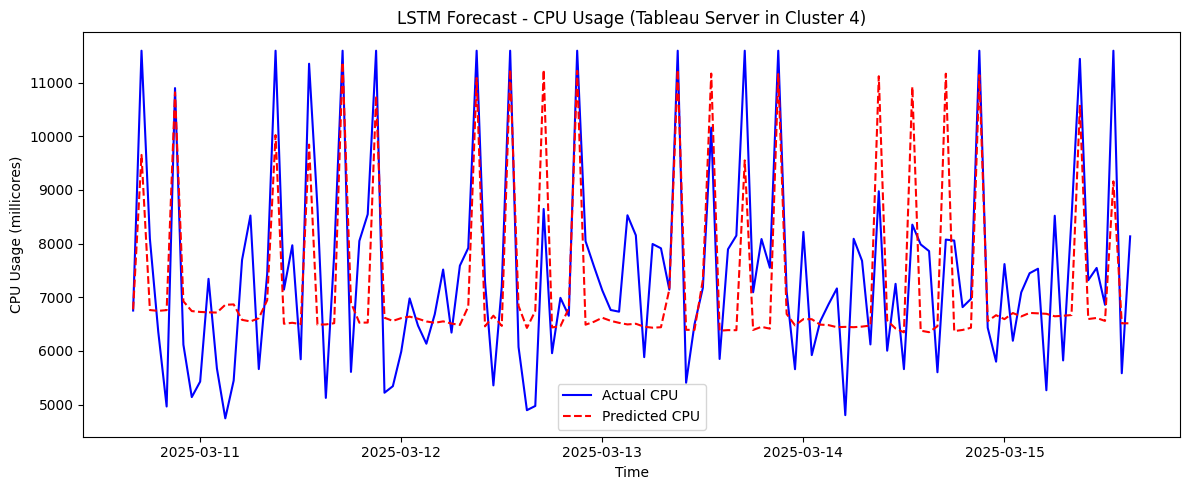

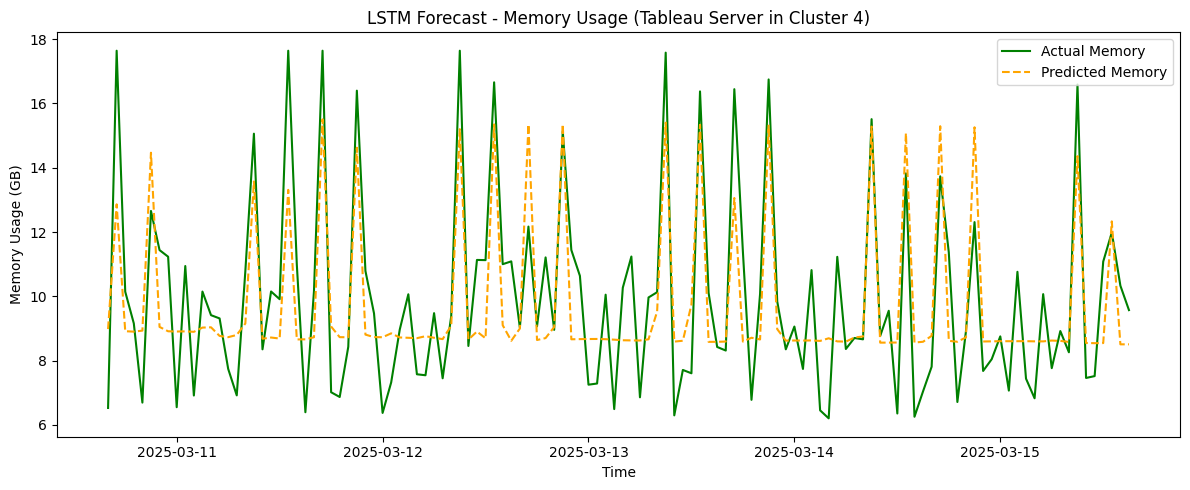


🔹 Sample 10 Predictions vs Actuals
2025-03-12 01:00:00 | Actual CPU: 6977.66, Predicted CPU: 6637.82, Actual Mem: 7.32, Predicted Mem: 8.85
2025-03-11 17:00:00 | Actual CPU: 11593.00, Predicted CPU: 11377.74, Actual Mem: 17.64, Predicted Mem: 15.51
2025-03-11 21:00:00 | Actual CPU: 11593.00, Predicted CPU: 10753.18, Actual Mem: 16.40, Predicted Mem: 14.62
2025-03-12 18:00:00 | Actual CPU: 5957.24, Predicted CPU: 6437.59, Actual Mem: 9.07, Predicted Mem: 8.64
2025-03-15 02:00:00 | Actual CPU: 7089.86, Predicted CPU: 6642.10, Actual Mem: 10.76, Predicted Mem: 8.61
2025-03-14 09:00:00 | Actual CPU: 8974.57, Predicted CPU: 11117.43, Actual Mem: 15.51, Predicted Mem: 15.28
2025-03-11 15:00:00 | Actual CPU: 5124.26, Predicted CPU: 6493.05, Actual Mem: 6.40, Predicted Mem: 8.66
2025-03-10 17:00:00 | Actual CPU: 11593.00, Predicted CPU: 9651.55, Actual Mem: 17.64, Predicted Mem: 12.86
2025-03-15 07:00:00 | Actual CPU: 5822.47, Predicted CPU: 6654.71, Actual Mem: 8.92, Predicted Mem: 8.62
2025

/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1169 - val_loss: 0.0668
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0722 - val_loss: 0.0649
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0711 - val_loss: 0.0636
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0681 - val_loss: 0.0651
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0718 - val_loss: 0.0645
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0675 - val_loss: 0.0625
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0651 - val_loss: 0.0602
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0658 - val_loss: 0.0590
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0658 - val_loss: 0.0568
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0609 - val_loss: 0.1009
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0901 - val_loss: 0.0646
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0705 - val_l

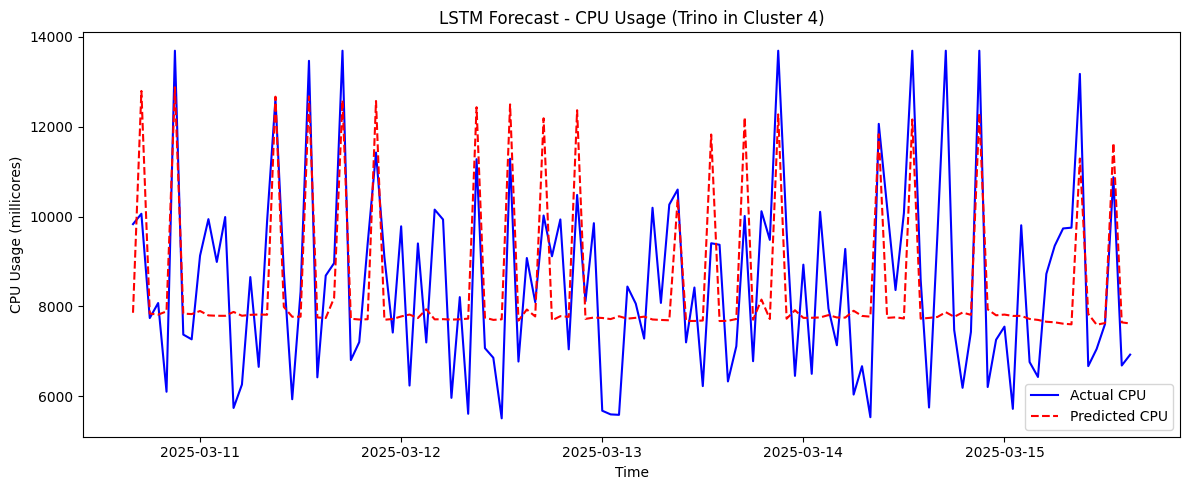

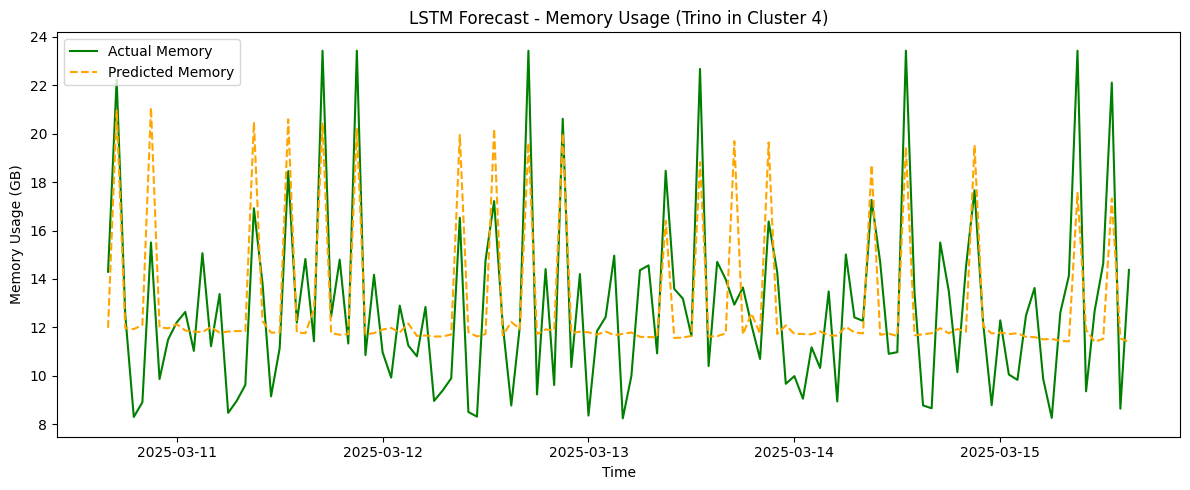


🔹 Sample 10 Predictions vs Actuals
2025-03-15 10:00:00 | Actual CPU: 6668.53, Predicted CPU: 7832.39, Actual Mem: 9.36, Predicted Mem: 11.90
2025-03-12 05:00:00 | Actual CPU: 9933.77, Predicted CPU: 7713.63, Actual Mem: 12.84, Predicted Mem: 11.67
2025-03-10 22:00:00 | Actual CPU: 7370.51, Predicted CPU: 7837.84, Actual Mem: 9.87, Predicted Mem: 12.00
2025-03-15 04:00:00 | Actual CPU: 6426.42, Predicted CPU: 7697.05, Actual Mem: 13.63, Predicted Mem: 11.60
2025-03-14 08:00:00 | Actual CPU: 5530.40, Predicted CPU: 7769.55, Actual Mem: 12.27, Predicted Mem: 11.75
2025-03-11 00:00:00 | Actual CPU: 9127.54, Predicted CPU: 7895.83, Actual Mem: 12.21, Predicted Mem: 12.13
2025-03-14 20:00:00 | Actual CPU: 7430.72, Predicted CPU: 7809.90, Actual Mem: 14.49, Predicted Mem: 11.82
2025-03-12 03:00:00 | Actual CPU: 7195.22, Predicted CPU: 7934.34, Actual Mem: 11.25, Predicted Mem: 12.16
2025-03-12 08:00:00 | Actual CPU: 5606.38, Predicted CPU: 7725.50, Actual Mem: 9.90, Predicted Mem: 11.71
2025

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load the resampled dataset
file_path = "/home/ashken.edirisinghe/Downloads/resampled_application_level.csv"
df = pd.read_csv(file_path)
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Choose charts from cluster 4 (same as hybrid model)
sample_cluster = 4
chart_list = df[df["Cluster ID"] == sample_cluster]["Chart Name"].unique()

for sample_chart in chart_list:
    print(f"\nRunning LSTM Forecast for: {sample_chart} (Cluster {sample_cluster})")

    df_sample = df[(df["Cluster ID"] == sample_cluster) & (df["Chart Name"] == sample_chart)].copy()
    df_sample.set_index("Timestamp", inplace=True)

    # Add time-based features
    df_sample["Hour"] = df_sample.index.hour
    df_sample["DayOfWeek"] = df_sample.index.dayofweek
    df_sample["IsWeekend"] = df_sample["DayOfWeek"].isin([5, 6]).astype(int)

    df_sample = df_sample[["CPU Used", "Memory Used (GB)", "Hour", "DayOfWeek", "IsWeekend"]]

    if len(df_sample) < 100:
        print("Skipped (insufficient data)")
        continue

    # Normalize data
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_sample), columns=df_sample.columns, index=df_sample.index)

    # Split data
    train_size = int(len(df_scaled) * 0.8)
    train, test = df_scaled[:train_size], df_scaled[train_size:]

    # Create sequences
    def create_sequences(data, target_columns, lookback=24):
        X, y = [], []
        for i in range(len(data) - lookback):
            X.append(data.iloc[i:i+lookback].values)
            y.append(data.iloc[i+lookback][target_columns].values)
        return np.array(X), np.array(y)

    lookback = 24
    X_train, y_train = create_sequences(train, ["CPU Used", "Memory Used (GB)"], lookback)
    X_test, y_test = create_sequences(test, ["CPU Used", "Memory Used (GB)"], lookback)

    # Build model
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(lookback, X_train.shape[2])),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(2)
    ])

    model.compile(optimizer='adam', loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

    # Predict
    y_pred = model.predict(X_test)

    # Only inverse transform CPU and Memory
    temp_df = pd.DataFrame(np.zeros((y_test.shape[0], df_sample.shape[1])), columns=df_sample.columns)
    temp_df[["CPU Used", "Memory Used (GB)"]] = y_test
    y_test_rescaled = scaler.inverse_transform(temp_df)[:, :2]

    temp_df[["CPU Used", "Memory Used (GB)"]] = y_pred
    y_pred_rescaled = scaler.inverse_transform(temp_df)[:, :2]

    y_test_final = y_test_rescaled
    y_pred_final = y_pred_rescaled

    # Evaluation
    def evaluate_forecast(actual, predicted):
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mape = np.mean(np.abs((actual - predicted) / np.maximum(actual, 1e-6))) * 100
        return mae, rmse, mape

    cpu_mae, cpu_rmse, cpu_mape = evaluate_forecast(y_test_final[:, 0], y_pred_final[:, 0])
    memory_mae, memory_rmse, memory_mape = evaluate_forecast(y_test_final[:, 1], y_pred_final[:, 1])

    print(f"CPU Usage - MAE: {cpu_mae:.2f}, RMSE: {cpu_rmse:.2f}, MAPE: {cpu_mape:.2f}%")
    print(f"Memory Usage - MAE: {memory_mae:.2f}, RMSE: {memory_rmse:.2f}, MAPE: {memory_mape:.2f}%")

    # Plot CPU
    plt.figure(figsize=(12, 5))
    plt.plot(test.index[lookback:], y_test_final[:, 0], label="Actual CPU", color="blue")
    plt.plot(test.index[lookback:], y_pred_final[:, 0], label="Predicted CPU", color="red", linestyle="--")
    plt.title(f"LSTM Forecast - CPU Usage ({sample_chart} in Cluster {sample_cluster})")
    plt.xlabel("Time")
    plt.ylabel("CPU Usage (millicores)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot Memory
    plt.figure(figsize=(12, 5))
    plt.plot(test.index[lookback:], y_test_final[:, 1], label="Actual Memory", color="green")
    plt.plot(test.index[lookback:], y_pred_final[:, 1], label="Predicted Memory", color="orange", linestyle="--")
    plt.title(f"LSTM Forecast - Memory Usage ({sample_chart} in Cluster {sample_cluster})")
    plt.xlabel("Time")
    plt.ylabel("Memory Usage (GB)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print 10 Samples
    sample_indices = np.random.choice(len(y_test_final), 10, replace=False)
    print("\n🔹 Sample 10 Predictions vs Actuals")
    for i in sample_indices:
        timestamp = test.index[lookback:][i]
        print(f"{timestamp} | Actual CPU: {y_test_final[i,0]:.2f}, Predicted CPU: {y_pred_final[i,0]:.2f}, Actual Mem: {y_test_final[i,1]:.2f}, Predicted Mem: {y_pred_final[i,1]:.2f}")


Future predictions

/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_mo

Epoch 1/50


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.3260 - val_loss: 0.2123
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2658 - val_loss: 0.1308
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1915 - val_loss: 0.2168
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1238 - val_loss: 0.1107
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1035 - val_loss: 0.0382
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1118 - val_loss: 0.0415
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0960 - val_loss: 0.0914
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0858 - val_loss: 0.1248
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0842 - val_loss: 0.0585
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0679 - val_loss: 0.0523
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0861 - val_loss: 0.0696
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0758 - val_loss: 0.0695
Epoch 13/50


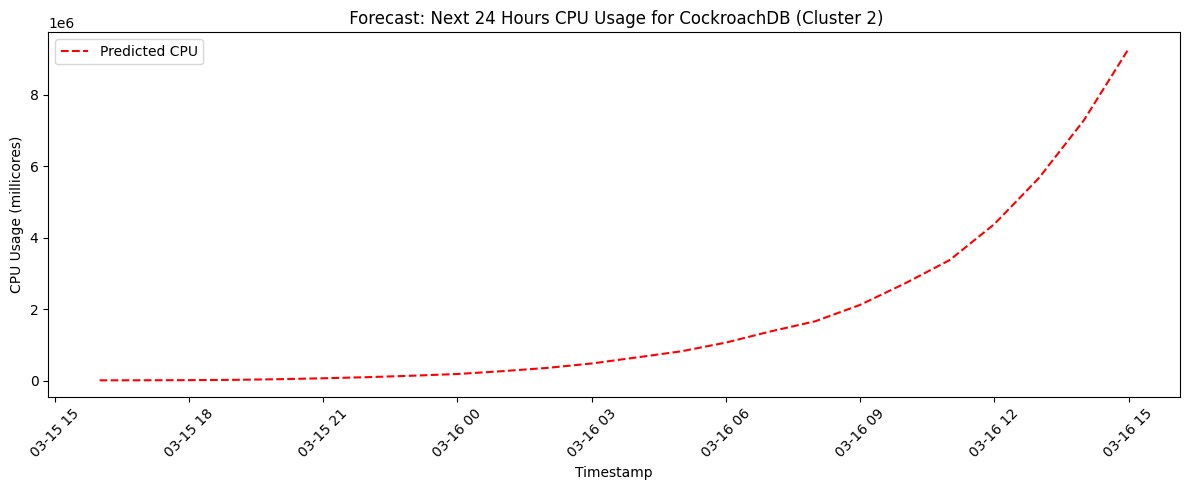

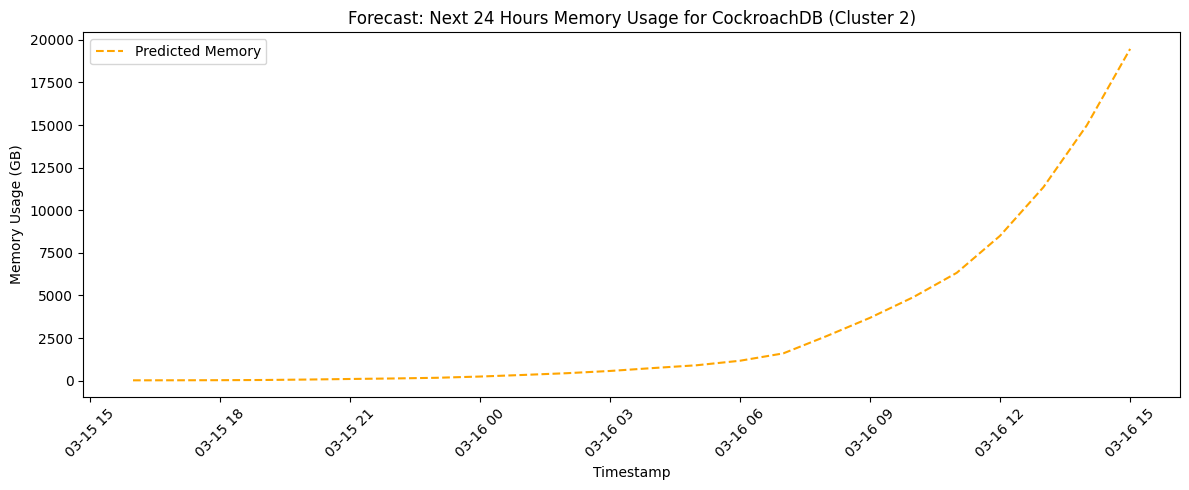

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
df = pd.read_csv("/home/ashken.edirisinghe/Downloads/resampled_application_level.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index("Timestamp", inplace=True)

# Select cluster and chart
sample_cluster = df["Cluster ID"].unique()[0]
sample_chart = df[df["Cluster ID"] == sample_cluster]["Chart Name"].unique()[0]
df_sample = df[(df["Cluster ID"] == sample_cluster) & (df["Chart Name"] == sample_chart)][["CPU Used", "Memory Used (GB)"]].copy()

# Normalize
scaler_raw = MinMaxScaler()
df_scaled = pd.DataFrame(scaler_raw.fit_transform(df_sample), columns=df_sample.columns, index=df_sample.index)

# Train-test split
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Train ARIMA
def train_arima(series, order, steps=24):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    return model_fit.forecast(steps=steps)

future_steps = 24
cpu_arima_future = train_arima(df_scaled["CPU Used"], (2, 0, 2), steps=future_steps)
mem_arima_future = train_arima(df_scaled["Memory Used (GB)"], (2, 0, 2), steps=future_steps)

# Prepare residuals for LSTM training
def compute_residuals(actual, predicted):
    return actual - predicted

# For residual training, use existing test set
cpu_arima_test = train_arima(train["CPU Used"], (2, 0, 2), steps=len(test))
mem_arima_test = train_arima(train["Memory Used (GB)"], (2, 0, 2), steps=len(test))
residuals_df = pd.DataFrame({
    "CPU Residuals": compute_residuals(test["CPU Used"].values, cpu_arima_test),
    "Memory Residuals": compute_residuals(test["Memory Used (GB)"].values, mem_arima_test)
}, index=test.index)

# Add time features
residuals_df["Hour"] = residuals_df.index.hour
residuals_df["DayOfWeek"] = residuals_df.index.dayofweek
residuals_df["IsWeekend"] = residuals_df["DayOfWeek"].isin([5, 6]).astype(int)

# Normalize residuals + time features
features = ["CPU Residuals", "Memory Residuals", "Hour", "DayOfWeek", "IsWeekend"]
scaler = MinMaxScaler()
residuals_scaled = pd.DataFrame(scaler.fit_transform(residuals_df[features]), columns=features, index=residuals_df.index)

# Create sequences for LSTM
def create_sequences(data, target_cols, lookback=24):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback].values)
        y.append(data.iloc[i+lookback][target_cols].values)
    return np.array(X), np.array(y)

lookback = 24
X_train, y_train = create_sequences(residuals_scaled, ["CPU Residuals", "Memory Residuals"], lookback)

# Train LSTM
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_lstm((lookback, X_train.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, callbacks=[early_stop], verbose=1)

# Auto-regressive future residual prediction
last_seq = residuals_scaled[-lookback:].copy()
future_residuals_scaled = []

# Prepare future timestamps
last_time = df_sample.index[-1]
future_times = pd.date_range(start=last_time + pd.Timedelta(hours=1), periods=future_steps, freq='H')

for ts in future_times:
    hour = ts.hour
    dow = ts.dayofweek
    is_weekend = 1 if dow in [5, 6] else 0

    time_feats = np.array([hour, dow, is_weekend]).reshape(1, 1, 3)
    last_input = last_seq.values[-lookback:]
    input_seq = np.hstack((last_input[:, :2], last_input[:, 2:]))  # already full
    input_seq = np.concatenate([input_seq[:-1], [[0, 0, hour, dow, is_weekend]]])  # roll in new time info
    prediction = model.predict(input_seq[np.newaxis, :, :], verbose=0)[0]
    future_residuals_scaled.append(prediction)

    # update sequence for next prediction
    next_row = np.hstack((prediction, [hour, dow, is_weekend]))
    last_seq.loc[ts] = next_row

# Inverse transform residuals
residuals_padded = np.hstack((future_residuals_scaled, np.zeros((future_steps, len(features) - 2))))
residuals_unscaled = scaler.inverse_transform(residuals_padded)[:, :2]

# Final forecast
cpu_final = cpu_arima_future + residuals_unscaled[:, 0]
mem_final = mem_arima_future + residuals_unscaled[:, 1]

# Denormalize
cpu_min, cpu_max = df_sample["CPU Used"].min(), df_sample["CPU Used"].max()
mem_min, mem_max = df_sample["Memory Used (GB)"].min(), df_sample["Memory Used (GB)"].max()
cpu_final_denorm = cpu_final * (cpu_max - cpu_min) + cpu_min
mem_final_denorm = mem_final * (mem_max - mem_min) + mem_min

# Plot future CPU forecast
plt.figure(figsize=(12, 5))
plt.plot(future_times, cpu_final_denorm, label="Predicted CPU", color="red", linestyle="--")
plt.title(f" Forecast: Next 24 Hours CPU Usage for {sample_chart} (Cluster {sample_cluster})")
plt.xlabel("Timestamp")
plt.ylabel("CPU Usage (millicores)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot future Memory forecast
plt.figure(figsize=(12, 5))
plt.plot(future_times, mem_final_denorm, label="Predicted Memory", color="orange", linestyle="--")
plt.title(f"Forecast: Next 24 Hours Memory Usage for {sample_chart} (Cluster {sample_cluster})")
plt.xlabel("Timestamp")
plt.ylabel("Memory Usage (GB)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


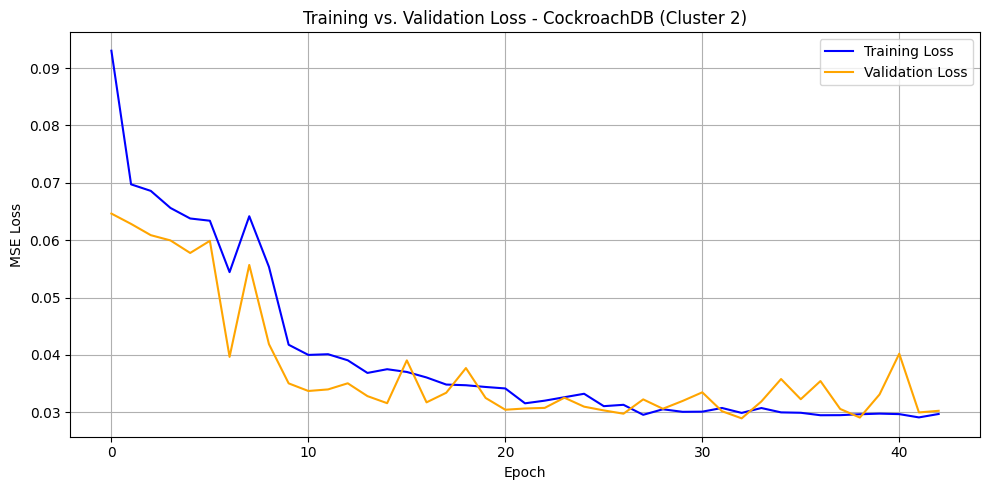

In [40]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title(f"Training vs. Validation Loss - {sample_chart} (Cluster {sample_cluster})")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Printing Residuals and EDA

2025-04-17 02:17:23.140100: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 02:17:23.267541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744836443.344800    5607 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744836443.370187    5607 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744836443.526714    5607 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Selected Cluster: 2, Selected Chart: CockroachDB


/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ashken.edirisinghe/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_mo

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.2573 - val_loss: 0.0887
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0916 - val_loss: 0.0610
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0690 - val_loss: 0.0677
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0769 - val_loss: 0.0588
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0638 - val_loss: 0.0534
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0686 - val_loss: 0.0525
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0629 - val_loss: 0.0540
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0667 - val_loss: 0.0514
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0592 - val_loss: 0.0511
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0566 - val_loss: 0.0516
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0580 - val_loss: 0.0505
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0620 - val_loss: 0.0502
E

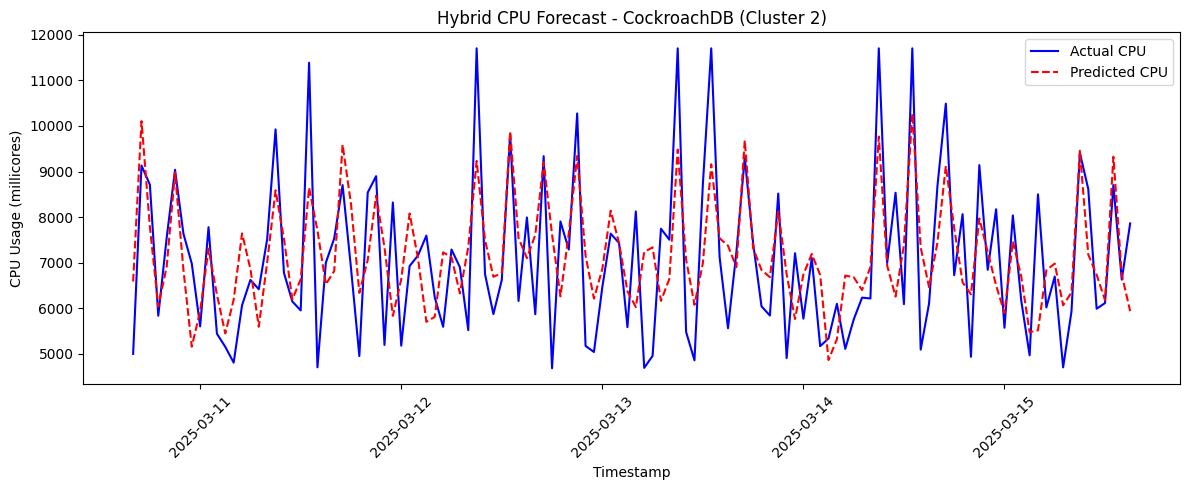

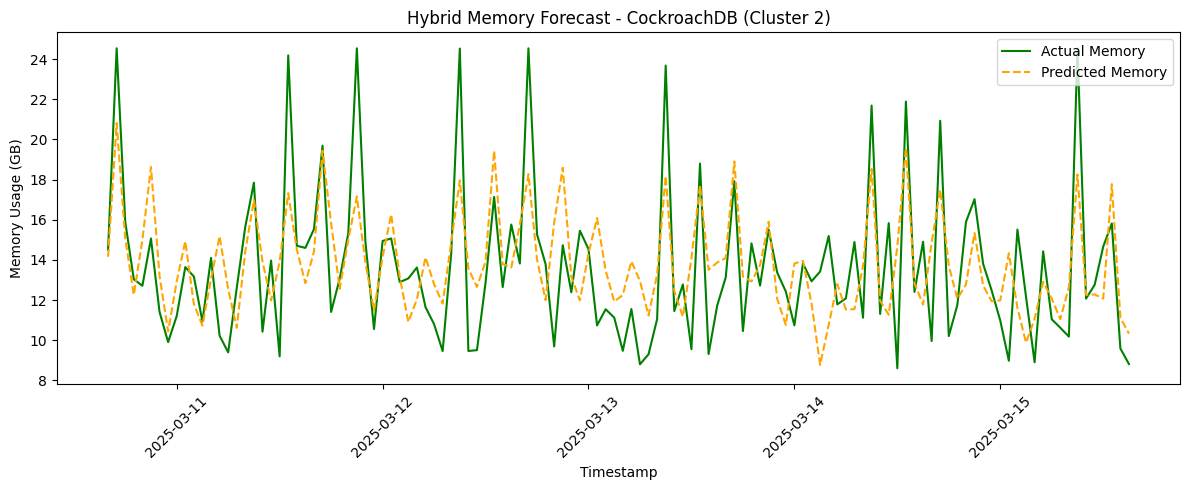

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

#  Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#  Load dataset
df = pd.read_csv("/home/ashken.edirisinghe/Downloads/resampled_application_level.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index("Timestamp", inplace=True)

#  Select a cluster and chart
sample_cluster = df["Cluster ID"].unique()[0]
sample_chart = df[df["Cluster ID"] == sample_cluster]["Chart Name"].unique()[0]
print(f"Selected Cluster: {sample_cluster}, Selected Chart: {sample_chart}")

#  Filter data
df_sample = df[(df["Cluster ID"] == sample_cluster) & (df["Chart Name"] == sample_chart)][["CPU Used", "Memory Used (GB)"]].copy()

#  Normalize full data
scaler_raw = MinMaxScaler()
df_scaled = pd.DataFrame(scaler_raw.fit_transform(df_sample), columns=df_sample.columns, index=df_sample.index)

#  Train-test split
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

#  Train ARIMA models
def train_arima(series, order):
    try:
        model = ARIMA(series, order=order)
        model_fit = model.fit()
        return model_fit.forecast(steps=len(test))
    except Exception as e:
        print(f"ARIMA failed: {e}")
        return None

cpu_forecast = train_arima(train["CPU Used"], (2, 0, 2))
memory_forecast = train_arima(train["Memory Used (GB)"], (2, 0, 2))

if cpu_forecast is None or memory_forecast is None:
    raise ValueError("ARIMA model training failed.")

#  Compute residuals
arima_forecast_df = pd.DataFrame({
    "CPU Used": cpu_forecast, 
    "Memory Used (GB)": memory_forecast
}, index=test.index)

cpu_residuals = test["CPU Used"] - arima_forecast_df["CPU Used"]
memory_residuals = test["Memory Used (GB)"] - arima_forecast_df["Memory Used (GB)"]

#  Feature engineering
residuals_df = pd.DataFrame({
    "CPU Residuals": cpu_residuals,
    "Memory Residuals": memory_residuals
}, index=test.index)

residuals_df["Hour"] = residuals_df.index.hour
residuals_df["DayOfWeek"] = residuals_df.index.dayofweek
residuals_df["IsWeekend"] = residuals_df["DayOfWeek"].isin([5, 6]).astype(int)

#  Normalize residuals + time features
scaler = MinMaxScaler()
features = ["CPU Residuals", "Memory Residuals", "Hour", "DayOfWeek", "IsWeekend"]
residuals_scaled = pd.DataFrame(scaler.fit_transform(residuals_df[features]), columns=features, index=residuals_df.index)

#  Sequence creation
def create_sequences(data, target_cols, lookback=24):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback].values)
        y.append(data.iloc[i+lookback][target_cols].values)
    return np.array(X), np.array(y)

lookback = 24
X_train, y_train = create_sequences(residuals_scaled, ["CPU Residuals", "Memory Residuals"], lookback)
X_test, y_test = create_sequences(residuals_scaled, ["CPU Residuals", "Memory Residuals"], lookback)

#  Build and train LSTM model
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = build_lstm((lookback, X_train.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

#  Predict residuals
residual_pred = lstm_model.predict(X_test)
residual_pred_rescaled = scaler.inverse_transform(
    np.hstack((residual_pred, np.zeros((residual_pred.shape[0], len(features) - 2))))
)[:, :2]

#  Final forecast = ARIMA + predicted residuals
trim_start = len(arima_forecast_df) - len(residual_pred_rescaled)
cpu_final = arima_forecast_df["CPU Used"].values[trim_start:] + residual_pred_rescaled[:, 0]
mem_final = arima_forecast_df["Memory Used (GB)"].values[trim_start:] + residual_pred_rescaled[:, 1]

#  Denormalize final values
cpu_min, cpu_max = df_sample["CPU Used"].min(), df_sample["CPU Used"].max()
mem_min, mem_max = df_sample["Memory Used (GB)"].min(), df_sample["Memory Used (GB)"].max()

actual_cpu = test.iloc[trim_start:]["CPU Used"] * (cpu_max - cpu_min) + cpu_min
actual_mem = test.iloc[trim_start:]["Memory Used (GB)"] * (mem_max - mem_min) + mem_min
pred_cpu = cpu_final * (cpu_max - cpu_min) + cpu_min
pred_mem = mem_final * (mem_max - mem_min) + mem_min

#  Print 10 Random Test Samples
test_samples = pd.DataFrame({
    "Actual CPU (millicores)": actual_cpu.sample(10, random_state=42).values,
    "Predicted CPU (millicores)": pred_cpu[:10],
    "Actual Memory (GB)": actual_mem.sample(10, random_state=42).values,
    "Predicted Memory (GB)": pred_mem[:10]
})

print("\n🔹 10 Random Test Samples (Denormalized):")
print(test_samples)

#  Plot CPU forecast
plt.figure(figsize=(12, 5))
plt.plot(actual_cpu.index, actual_cpu, label="Actual CPU", color="blue")
plt.plot(actual_cpu.index, pred_cpu, label="Predicted CPU", color="red", linestyle="--")
plt.title(f"Hybrid CPU Forecast - {sample_chart} (Cluster {sample_cluster})")
plt.xlabel("Timestamp")
plt.ylabel("CPU Usage (millicores)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Plot Memory forecast
plt.figure(figsize=(12, 5))
plt.plot(actual_mem.index, actual_mem, label="Actual Memory", color="green")
plt.plot(actual_mem.index, pred_mem, label="Predicted Memory", color="orange", linestyle="--")
plt.title(f"Hybrid Memory Forecast - {sample_chart} (Cluster {sample_cluster})")
plt.xlabel("Timestamp")
plt.ylabel("Memory Usage (GB)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

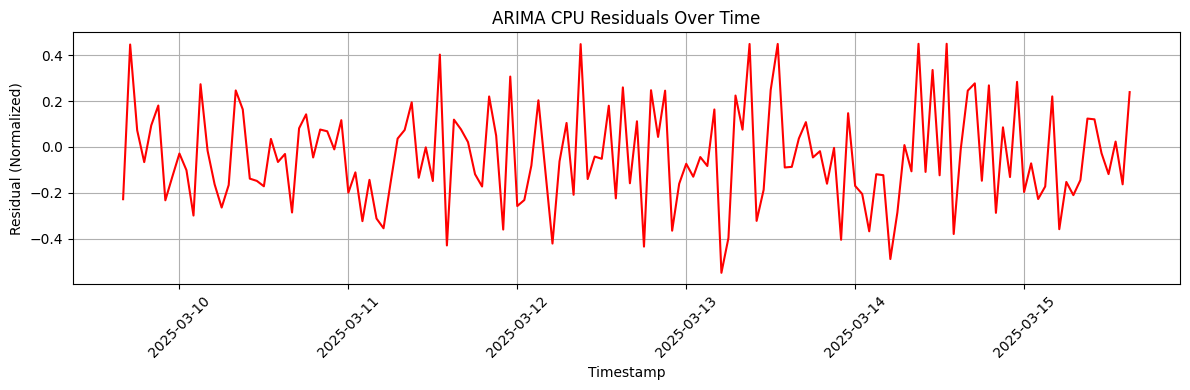

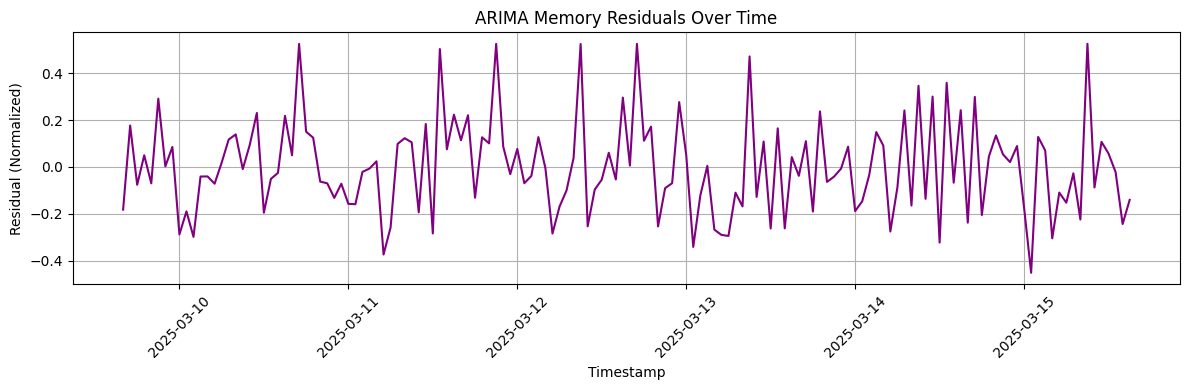

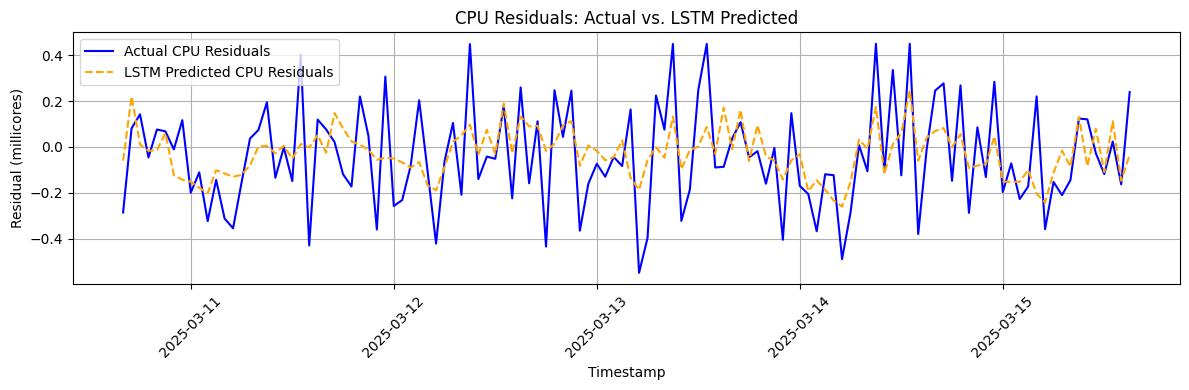

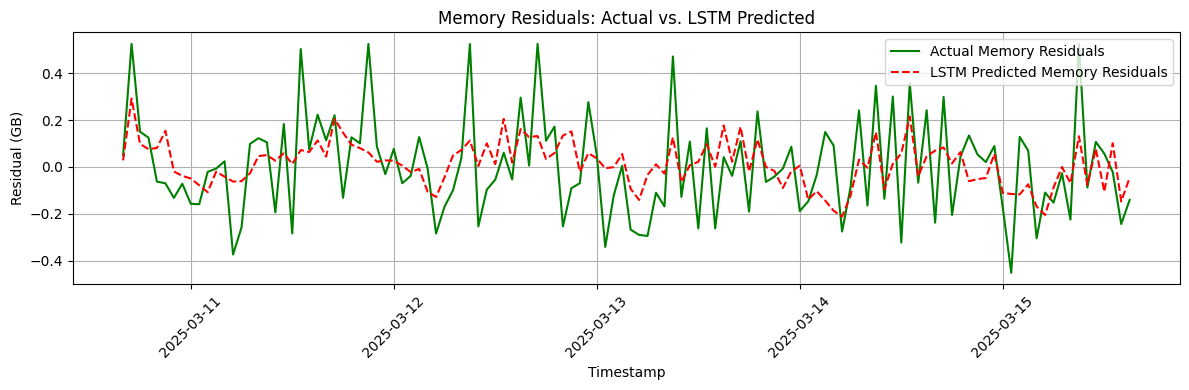

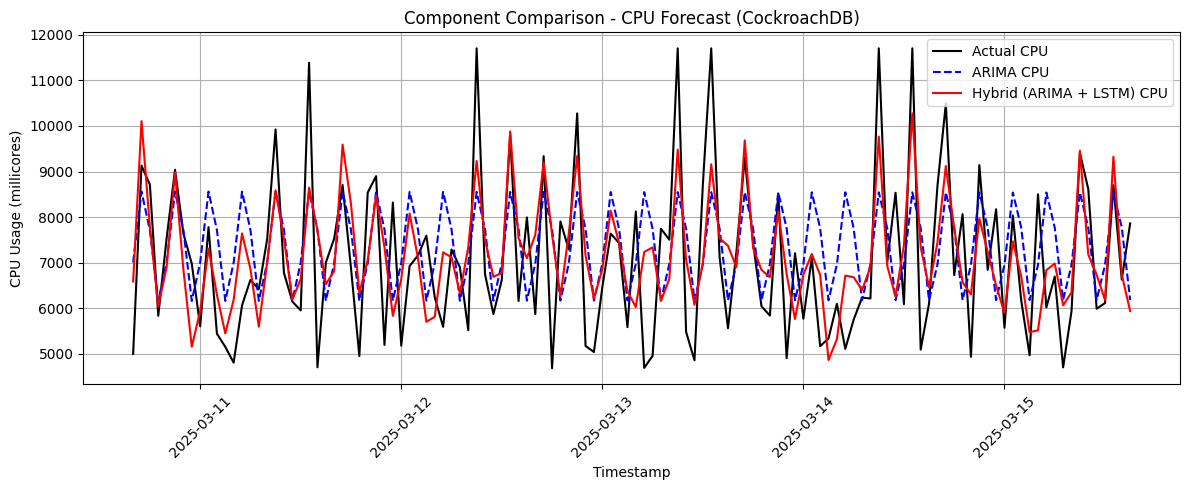

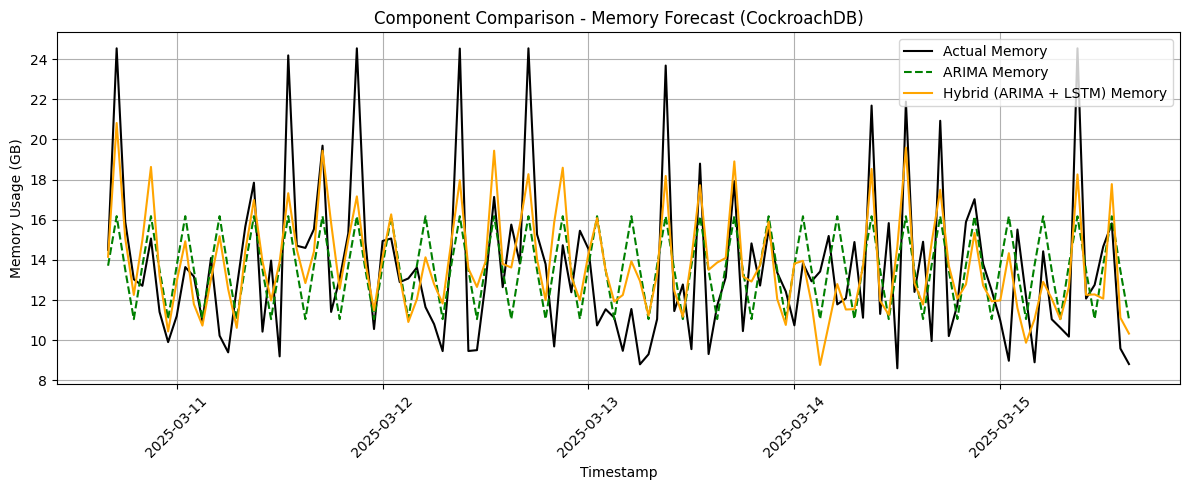

In [2]:
#  1. ARIMA Residuals (CPU & Memory)
plt.figure(figsize=(12, 4))
plt.plot(cpu_residuals.index, cpu_residuals, label="CPU Residuals (Actual - ARIMA)", color="red")
plt.title("ARIMA CPU Residuals Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Residual (Normalized)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(memory_residuals.index, memory_residuals, label="Memory Residuals (Actual - ARIMA)", color="purple")
plt.title("ARIMA Memory Residuals Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Residual (Normalized)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


#  Compare Actual Residuals vs. LSTM-Predicted Residuals
plt.figure(figsize=(12, 4))
plt.plot(cpu_residuals.index[lookback:], cpu_residuals.iloc[lookback:], label="Actual CPU Residuals", color="blue")
plt.plot(cpu_residuals.index[lookback:], residual_pred_rescaled[:, 0], label="LSTM Predicted CPU Residuals", color="orange", linestyle="--")
plt.title("CPU Residuals: Actual vs. LSTM Predicted")
plt.xlabel("Timestamp")
plt.ylabel("Residual (millicores)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(memory_residuals.index[lookback:], memory_residuals.iloc[lookback:], label="Actual Memory Residuals", color="green")
plt.plot(memory_residuals.index[lookback:], residual_pred_rescaled[:, 1], label="LSTM Predicted Memory Residuals", color="red", linestyle="--")
plt.title("Memory Residuals: Actual vs. LSTM Predicted")
plt.xlabel("Timestamp")
plt.ylabel("Residual (GB)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Compare ARIMA vs Hybrid Forecast vs Actual (CPU)
plt.figure(figsize=(12, 5))
plt.plot(actual_cpu.index, actual_cpu, label="Actual CPU", color="black")
plt.plot(actual_cpu.index, arima_forecast_df["CPU Used"].iloc[trim_start:] * (cpu_max - cpu_min) + cpu_min, 
         label="ARIMA CPU", color="blue", linestyle="dashed")
plt.plot(actual_cpu.index, pred_cpu, label="Hybrid (ARIMA + LSTM) CPU", color="red")
plt.title(f"Component Comparison - CPU Forecast ({sample_chart})")
plt.xlabel("Timestamp")
plt.ylabel("CPU Usage (millicores)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Compare ARIMA vs Hybrid Forecast vs Actual (Memory)
plt.figure(figsize=(12, 5))
plt.plot(actual_mem.index, actual_mem, label="Actual Memory", color="black")
plt.plot(actual_mem.index, arima_forecast_df["Memory Used (GB)"].iloc[trim_start:] * (mem_max - mem_min) + mem_min, 
         label="ARIMA Memory", color="green", linestyle="dashed")
plt.plot(actual_mem.index, pred_mem, label="Hybrid (ARIMA + LSTM) Memory", color="orange")
plt.title(f"Component Comparison - Memory Forecast ({sample_chart})")
plt.xlabel("Timestamp")
plt.ylabel("Memory Usage (GB)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
